
# Discrete‑Time SEIR Model for Dengue (Vietnam 2005‑2019)

This notebook walks through a **reproducible workflow** to train a monthly SEIR model
on the prepared dengue case data (`dengue_2005_2019_national.csv`)
and incorporate climate covariates (rainfall & 2‑m temperature, ERA5).

## Lý thuyết về Discrete Epidemic Models

**Mô hình dịch tễ rời rạc (Discrete Epidemic Models)** khác với mô hình liên tục ở chỗ:
- **Continuous models**: Sử dụng hệ phương trình vi phân (ODE) với thời gian liên tục
- **Discrete models**: Cập nhật các compartments theo từng bước thời gian rời rạc (Δt)

**Ưu điểm của Discrete Models:**
- Phù hợp với dữ liệu quan sát theo chu kỳ (hàng tháng, hàng tuần)
- Dễ tích hợp các biến ngoại sinh (climate, interventions)
- Tính toán đơn giản và trực quan hơn

**Mô hình SEIR cho sốt xuất huyết:**
- **S** (Susceptible): Dân số dễ mắc bệnh
- **E** (Exposed): Đã nhiễm nhưng chưa có triệu chứng (thời gian ủ bệnh)
- **I** (Infectious): Đang truyền bệnh
- **R** (Recovered): Đã khỏi bệnh và có miễn dịch

**Sections**

1. Load libraries & data  
2. Exploratory visualisation  
3. Pre‑process climate (aggregate to national / regional level, add lags)  
4. Build discrete SEIR formulation  
5. Parameter calibration (least‑squares)  
6. Forecast & evaluation

> **Time step**: 1 month  
> **Compartments**: S, E, I, R (human only, implicit vector effect via β(t) climate function)


In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.optimize import minimize, dual_annealing
from scipy.stats import nbinom  # For overdispersion (negative binomial)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

In [2]:
# --- Model Configuration ---
config = {
    "normalize_cases": "per_capita",   # options: absolute, per_capita, zscore
    "per_capita_scale": 1e5,            # cases per 100k population
    "loss_on_log_scale": False,  
    "loss_epsilon": 1e-6,               # floor to avoid log(0)
    "climate_lags": [1, 2, 3],          # multi-lag climate features
    "seasonal_harmonics": 2,            # number of annual harmonics for seasonality
    "beta_intercept_bounds": (-2.0, 1.0),  
    "beta_feature_bounds": (-1.5, 1.5),
    "sigma_bounds": (3.0, 5.0),         # incubation rate range per month (~4-7 days)
    "gamma_bounds": (2.0, 4.0),         # infectious rate range per month (~7-12 days)
    "random_restarts": 20,
    "global_optimization": True,
    "global_maxiter": 500,
    "random_seed": 42,
    # Regularization and overdispersion
    "use_regularization": True,
    "l2_regularization": 0.1,
    "use_overdispersion": True,
    "overdispersion_bounds": (0.1, 10.0),
    "fixed_sigma": 3.5,
    "fixed_gamma": 2.5,
    "fourier_sum_max": 0.8,
    "initial_immune_fraction": 0.15,
    "initial_state_n_months": 6,
    # Weighted loss function (prioritize peak fitting)
    "use_weighted_loss": True,
    "weighted_loss_method": "percentile",
    "weighted_loss_percentile": 75,
    "weighted_loss_threshold": None,
    "weighted_loss_peak_weight": 3.0,
    "weighted_loss_smooth": True
}

np.random.seed(config["random_seed"])



In [3]:
# --- Load Data ---
cases_path = 'Dataset Processing/dengue_2005_2019_national.csv'  # Updated: using prepared 2005-2019 data
rain_nc = 'data_stream-moda_stepType-avgad.nc'   # total precipitation
temp_nc = 'data_stream-moda_stepType-avgua.nc'   # 2‑m air temperature
pop_path = 'population/vietnam_population_2005_2024.csv'

# --- Load dengue cases (national level, already prepared) ---
cases = pd.read_csv(cases_path, parse_dates=['YearMonth'])
# File already contains only National level data, so we can use it directly
national = cases[['YearMonth', 'dengue_total_month']].copy()
national = national.rename(columns={'dengue_total_month':'incidence'})
national = national.set_index('YearMonth')
national.index = national.index + pd.offsets.MonthEnd(0)  # align with month-end climate aggregation

print("Case series shape:", national.shape)
print("Date range:", national.index.min(), "to", national.index.max())

# --- Load climate ---
rain_ds = xr.open_dataset(rain_nc)
temp_ds = xr.open_dataset(temp_nc)

# National spatial mean (masking lat/lon over Vietnam already)
rain_series = (
    rain_ds['tp']
    .mean(dim=['latitude','longitude'])
    .to_pandas()
)
temp_series = (
    temp_ds['t2m']
    .mean(dim=['latitude','longitude'])
    .to_pandas()
)

# --- Convert units before standardization ---
# Convert rainfall from meters (m) to millimeters (mm): multiply by 1000
rain_series = rain_series * 1000  # m → mm

# Convert temperature from Kelvin (K) to Celsius (°C): subtract 273.15
temp_series = temp_series - 273.15  # K → °C

print(f"Rainfall unit: mm (converted from m)")
print(f"Temperature unit: °C (converted from K)")
print(f"Rainfall range: {rain_series.min():.2f} - {rain_series.max():.2f} mm")
print(f"Temperature range: {temp_series.min():.2f} - {temp_series.max():.2f} °C")

# Align indexes
climate = pd.concat({'rain': rain_series, 'temp': temp_series}, axis=1)
climate.index = pd.to_datetime(climate.index)
climate = climate.resample('ME').mean()

# --- Load population data ---
pop_df = pd.read_csv(pop_path)
pop_df['YearMonth'] = pd.to_datetime(pop_df['year'].astype(str) + '-01-01')
pop_df = pop_df.set_index('YearMonth')['population']
# Align annual population points to month-end to match climate/cases
pop_df.index = pop_df.index + pd.offsets.MonthEnd(0)

# Interpolate population to monthly values
# Create monthly index for the date range
monthly_index = pd.date_range(start=national.index.min(), end=national.index.max(), freq='ME')
# Reindex to monthly grid, then interpolate over time and fill edges
pop_monthly = (
    pop_df.reindex(monthly_index)
          .interpolate(method='time')
          .ffill()
          .bfill()
)

print(f"Population range: {pop_monthly.min():,.0f} - {pop_monthly.max():,.0f}")

# Merge with incidence
df = national.join(climate, how='inner')
df = df.join(pop_monthly, how='inner')
df.rename(columns={'population': 'N'}, inplace=True)

print(f"\nData shape after merging: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
df.head()


Case series shape: (180, 1)
Date range: 2005-01-31 00:00:00 to 2019-12-31 00:00:00
Rainfall unit: mm (converted from m)
Temperature unit: °C (converted from K)
Rainfall range: 0.53 - 13.73 mm
Temperature range: 19.71 - 28.84 °C
Population range: 81,088,313 - 97,173,776

Data shape after merging: (180, 4)
Date range: 2005-01-31 00:00:00 to 2019-12-31 00:00:00


,incidence,rain,temp,N
2005-01-31,3133.207218,0.692597,21.037903,8.108831e+07
2005-02-28,1832.849710,0.694412,23.361176,8.117113e+07
2005-03-31,1673.512896,1.473924,23.509796,8.126282e+07
2005-04-30,1557.761488,1.924214,26.196259,8.135155e+07
2005-05-31,2160.990661,4.701515,27.647949,8.144324e+07


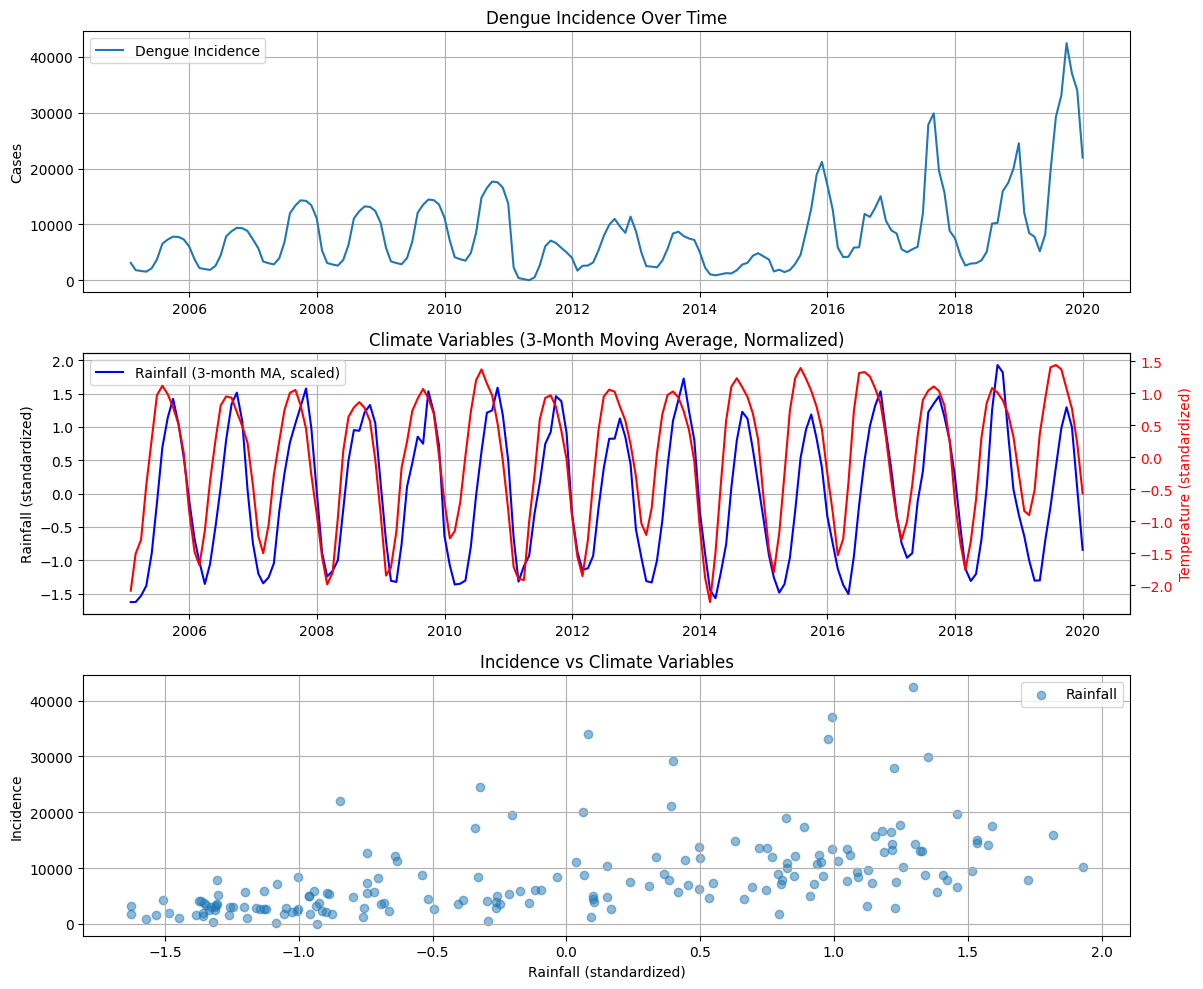

,incidence,rain_scaled,temp_scaled,N
count,180.000000,1.800000e+02,1.800000e+02,1.800000e+02
mean,8430.633333,-1.085551e-16,2.516506e-15,8.992931e+07
std,7211.781194,1.002789e+00,1.002789e+00,4.875353e+06
min,19.000000,-1.627593e+00,-2.258871e+00,8.108831e+07
25%,3188.000000,-9.469072e-01,-8.783656e-01,8.611001e+07
50%,6446.865513,5.066159e-02,2.742742e-01,8.999382e+07
75%,11526.000000,9.373586e-01,8.924783e-01,9.421716e+07
max,42451.000000,1.929347e+00,1.441792e+00,9.717378e+07


In [4]:
# --- Feature Engineering: Climate Variables with 3-Month Moving Average ---
# Sử dụng giá trị trung bình trượt 3 tháng (3-month moving average) thay vì lag
ma_window = 3  # window size for moving average (months)

# Tạo moving average climate features (raw values)
# Rolling mean tính trung bình của tháng hiện tại và 2 tháng trước đó
df['rain_lag_raw'] = df['rain'].rolling(window=ma_window, min_periods=1).mean()
df['temp_lag_raw'] = df['temp'].rolling(window=ma_window, min_periods=1).mean()

# Drop rows with missing values (first 2 months will have incomplete moving average)
# Note: min_periods=1 allows first month, but we drop NaN for consistency
df = df.dropna().copy()

# Note: Scaled features for visualization only; scaling for modeling is done separately on training data to avoid data leakage
climate_scaler_rain_viz = StandardScaler()
climate_scaler_temp_viz = StandardScaler()
df['rain_lag_scaled'] = climate_scaler_rain_viz.fit_transform(df[['rain_lag_raw']]).ravel()
df['temp_lag_scaled'] = climate_scaler_temp_viz.fit_transform(df[['temp_lag_raw']]).ravel()

# Compute time index t (months since January 2005 = 0)
reference_date = pd.Timestamp('2005-01-01')
df['t_months'] = (df.index.year - reference_date.year) * 12 + (df.index.month - reference_date.month)

# Convenience aliases for exploratory plots
df['rain_scaled'] = df['rain_lag_scaled']
df['temp_scaled'] = df['temp_lag_scaled']

# Exploratory visualization
fig, axes = plt.subplots(3, 1, figsize=(12, 10))
axes[0].plot(df.index, df['incidence'], label='Dengue Incidence')
axes[0].set_ylabel('Cases')
axes[0].set_title('Dengue Incidence Over Time')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(df.index, df['rain_scaled'], label=f"Rainfall (3-month MA, scaled)", color='blue')
axes[1].set_ylabel('Rainfall (standardized)')
axes[1].set_title('Climate Variables (3-Month Moving Average, Normalized)')
axes[1].legend()
axes[1].grid(True)

ax2 = axes[1].twinx()
ax2.plot(df.index, df['temp_scaled'], label=f"Temperature (3-month MA, scaled)", color='red')
ax2.set_ylabel('Temperature (standardized)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

axes[2].scatter(df['rain_scaled'], df['incidence'], alpha=0.5, label='Rainfall')
axes[2].set_xlabel('Rainfall (standardized)')
axes[2].set_ylabel('Incidence')
axes[2].set_title('Incidence vs Climate Variables')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Summary statistics
summary_cols = ['incidence', 'rain_scaled', 'temp_scaled', 'N']
df[summary_cols].describe()


In [5]:
# --- Target transformation helpers (cases vs rates vs z-score) ---
def fit_target_transform(values, populations):
    method = config['normalize_cases']
    values = np.asarray(values, dtype=float)
    populations = np.asarray(populations, dtype=float)

    if method == 'per_capita':
        transformed = (values / populations) * config['per_capita_scale']
        meta = {"method": method}
    elif method == 'zscore':
        mean = values.mean()
        std = values.std(ddof=0)
        std = std if std > 0 else 1.0
        transformed = (values - mean) / std
        meta = {"method": method, "mean": float(mean), "std": float(std)}
    else:  # absolute counts
        transformed = values
        meta = {"method": method}
    return transformed, meta


def apply_target_transform(values, populations, meta):
    method = meta.get('method', config['normalize_cases'])
    values = np.asarray(values, dtype=float)
    populations = np.asarray(populations, dtype=float)

    if method == 'per_capita':
        return (values / populations) * config['per_capita_scale']
    elif method == 'zscore':
        mean = meta['mean']
        std = meta['std'] if meta['std'] != 0 else 1.0
        return (values - mean) / std
    else:
        return values


target_values, target_meta = fit_target_transform(df['incidence'].values, df['N'].values)

# Pre-compute optimization arrays for Fourier-based beta model
rain_data_full = df['rain_lag_scaled'].values.astype(float)
temp_data_full = df['temp_lag_scaled'].values.astype(float)
t_months_full = df['t_months'].values.astype(float)
observed_cases_full = df['incidence'].values.astype(float)
observed_target_full = target_values
population_full = df['N'].values.astype(float)


def transform_cases_to_target(values, populations, meta=None):
    """Apply the configured target transform to arbitrary incidence series."""
    meta = target_meta if meta is None else meta
    return apply_target_transform(values, populations, meta)


# --- SEIR Objective Function (for calibration) ---
def seir_objective(params, initial_state, populations, rain_data, temp_data, t_months, observed_target):
    """
    Objective function for SEIR model calibration with REPORTING RATE (Rho).
    Computes MSE between observed and simulated target values.
    """
    try:
        # Extract Reporting Rate (Rho) - Assumed to be the LAST parameter
        rho = params[-1]
        seir_params = params[:-1]
        
        # Tighter constraint: α1 + α2 < fourier_sum_max (default 0.8)
        fourier_max = config.get('fourier_sum_max', 0.8)
        # Note: indices shifted because seir_params is now a slice
        if seir_params[3] + seir_params[5] >= fourier_max:
            return 1e10
        
        # Simulate returns TRUE incidence (Total infections)
        sim_incidence_true, _ = simulate_seir(seir_params, initial_state.copy(), populations, rain_data, temp_data, t_months)
        
        # Apply Reporting Rate: Reported = True * Rho
        sim_incidence_reported = sim_incidence_true * rho
        
        sim_target = transform_cases_to_target(sim_incidence_reported, populations)

        if config['loss_on_log_scale']:
            sim_vals = np.log(sim_target + config['loss_epsilon'])
            obs_vals = np.log(observed_target + config['loss_epsilon'])
        else:
            sim_vals = sim_target
            obs_vals = observed_target

        residuals = sim_vals - obs_vals
        
        # Standard MSE
        loss = weighted_mse(residuals, observed_target)
        
        if not np.isfinite(loss):
            return 1e10
        return loss
    except Exception:
        return 1e10


def weighted_mse(residuals, reference):
    """Weighted MSE to emphasize outbreak peaks when enabled."""
    if not config.get('use_weighted_loss', False):
        return float(np.mean(residuals ** 2))

    residuals = np.asarray(residuals, dtype=float).ravel()
    reference = np.asarray(reference, dtype=float).ravel()
    if residuals.size == 0:
        return 0.0

    peak_weight = float(config.get('weighted_loss_peak_weight', 1.0))
    if peak_weight <= 1.0:
        return float(np.mean(residuals ** 2))

    method = config.get('weighted_loss_method', 'percentile')
    threshold = config.get('weighted_loss_threshold')
    percentile = float(config.get('weighted_loss_percentile', 75.0))
    smooth = bool(config.get('weighted_loss_smooth', True))

    if method == 'threshold' and threshold is not None:
        cutoff = float(threshold)
    else:
        cutoff = np.percentile(reference, percentile)

    if not np.isfinite(cutoff) or cutoff <= 0:
        cutoff = 1.0

    denom = max(cutoff, 1e-9)
    excess = np.clip((reference - cutoff) / denom, 0.0, None)

    if smooth:
        weights = 1.0 + (peak_weight - 1.0) * np.clip(excess, 0.0, 1.0)
    else:
        weights = np.where(reference >= cutoff, peak_weight, 1.0)

    weight_sum = np.sum(weights)
    if weight_sum <= 0:
        return float(np.mean(residuals ** 2))

    return float(np.sum(weights * residuals ** 2) / weight_sum)


In [6]:
# --- SEIR Model Functions ---

# --- Discrete SEIR model definition (Exponential Form) ---
def seir_step(state, beta, sigma, gamma, N, dt=1.0):
    """
    One time step of discrete SEIR model using exponential form
    """
    S, E, I, R = state
    
    # Ensure non-negative compartments
    S = max(0, float(S))
    E = max(0, float(E))
    I = max(0, float(I))
    R = max(0, float(R))
    
    # New infections (force of infection)
    if I > 0 and S > 0:
        force_of_infection = beta * I / N
        new_exposed = S * (1 - np.exp(-force_of_infection * dt))
        new_exposed = min(new_exposed, S)
    else:
        new_exposed = 0.0
    
    # Progression from exposed to infectious
    if E > 0:
        new_infectious = E * (1 - np.exp(-sigma * dt))
        new_infectious = min(new_infectious, E)
    else:
        new_infectious = 0.0
    
    # Recovery
    if I > 0:
        new_removed = I * (1 - np.exp(-gamma * dt))
        new_removed = min(new_removed, I)
    else:
        new_removed = 0.0
    
    # Update compartments
    S_next = S - new_exposed
    E_next = E + new_exposed - new_infectious
    I_next = I + new_infectious - new_removed
    R_next = R + new_removed
    
    # Ensure non-negative and conservation of total population
    total = S_next + E_next + I_next + R_next
    if total > 0:
        S_next = max(0, S_next * N / total)
        E_next = max(0, E_next * N / total)
        I_next = max(0, I_next * N / total)
        R_next = max(0, R_next * N / total)
    
    return np.array([S_next, E_next, I_next, R_next]), new_infectious

def simulate_seir(params, initial_state, N_array, rain_data, temp_data, t_months):
    """
    Simulate SEIR model over time.
    NOTE: Params list length depends on configuration (Rho, etc.)
    """
    # Handle variable parameter length (Basic SEIR vs SEIR+Rho)
    # We extract standard parameters first
    beta0, b_rain, b_temp, alpha1, phi1, alpha2, phi2, sigma, gamma = params[:9]
    
    S, E, I, R = initial_state
    traj_incidence = []
    traj_states = []
    
    n_steps = len(rain_data)
    if isinstance(N_array, (int, float)):
        N_array = np.full(n_steps, N_array)
    elif isinstance(N_array, pd.Series):
        N_array = N_array.values
        
    rain_data = np.asarray(rain_data, dtype=float).ravel()
    temp_data = np.asarray(temp_data, dtype=float).ravel()
    t_months = np.asarray(t_months, dtype=float).ravel()
    
    for idx in range(n_steps):
        N = N_array[idx] if idx < len(N_array) else N_array[-1]
        
        climate_part = np.exp(b_rain * rain_data[idx] + b_temp * temp_data[idx])
        
        t = t_months[idx]
        fourier_part = 1.0 + alpha1 * np.sin(2 * np.pi * t / 12.0 + phi1) + alpha2 * np.sin(2 * np.pi * t / 6.0 + phi2)
        fourier_part = max(1e-6, fourier_part)
        
        beta = np.exp(beta0) * climate_part * fourier_part
        beta = max(1e-10, beta)
        
        # Adjust compartments if population changed
        current_total = S + E + I + R
        if N != current_total and current_total > 0:
            scale = N / current_total
            S *= scale
            E *= scale
            I *= scale
            R *= scale
        
        (S, E, I, R), new_cases = seir_step((S, E, I, R), beta, sigma, gamma, N, dt=1.0)
        
        traj_incidence.append(new_cases)
        traj_states.append([S, E, I, R])
    
    return np.array(traj_incidence), np.array(traj_states)



In [7]:
# --- Target transformation helpers (cases vs rates vs z-score) ---
def fit_target_transform(values, populations):
    method = config['normalize_cases']
    values = np.asarray(values, dtype=float)
    populations = np.asarray(populations, dtype=float)

    if method == 'per_capita':
        transformed = (values / populations) * config['per_capita_scale']
        meta = {"method": method}
    elif method == 'zscore':
        mean = values.mean()
        std = values.std(ddof=0)
        std = std if std > 0 else 1.0
        transformed = (values - mean) / std
        meta = {"method": method, "mean": float(mean), "std": float(std)}
    else:  # absolute counts
        transformed = values
        meta = {"method": method}
    return transformed, meta


def apply_target_transform(values, populations, meta):
    method = meta.get('method', config['normalize_cases'])
    values = np.asarray(values, dtype=float)
    populations = np.asarray(populations, dtype=float)

    if method == 'per_capita':
        return (values / populations) * config['per_capita_scale']
    elif method == 'zscore':
        mean = meta['mean']
        std = meta['std'] if meta['std'] != 0 else 1.0
        return (values - mean) / std
    else:
        return values


target_values, target_meta = fit_target_transform(df['incidence'].values, df['N'].values)

# Pre-compute optimization arrays for Fourier-based beta model
rain_data_full = df['rain_lag_scaled'].values.astype(float)
temp_data_full = df['temp_lag_scaled'].values.astype(float)
t_months_full = df['t_months'].values.astype(float)
observed_cases_full = df['incidence'].values.astype(float)
observed_target_full = target_values
population_full = df['N'].values.astype(float)


def transform_cases_to_target(values, populations, meta=None):
    """Apply the configured target transform to arbitrary incidence series."""
    meta = target_meta if meta is None else meta
    return apply_target_transform(values, populations, meta)


# --- SEIR Objective Function (for calibration) ---
def seir_objective(params, initial_state, populations, rain_data, temp_data, t_months, observed_target):
    """
    Objective function for SEIR model calibration with REPORTING RATE (Rho).
    Computes MSE between observed and simulated target values.
    """
    try:
        # Extract Reporting Rate (Rho) - Assumed to be the LAST parameter
        rho = params[-1]
        seir_params = params[:-1]
        
        # Tighter constraint: α1 + α2 < fourier_sum_max (default 0.8)
        fourier_max = config.get('fourier_sum_max', 0.8)
        # Note: indices shifted because seir_params is now a slice
        if seir_params[3] + seir_params[5] >= fourier_max:
            return 1e10
        
        # Simulate returns TRUE incidence (Total infections)
        sim_incidence_true, _ = simulate_seir(seir_params, initial_state.copy(), populations, rain_data, temp_data, t_months)
        
        # Apply Reporting Rate: Reported = True * Rho
        sim_incidence_reported = sim_incidence_true * rho
        
        sim_target = transform_cases_to_target(sim_incidence_reported, populations)

        if config['loss_on_log_scale']:
            sim_vals = np.log(sim_target + config['loss_epsilon'])
            obs_vals = np.log(observed_target + config['loss_epsilon'])
        else:
            sim_vals = sim_target
            obs_vals = observed_target

        residuals = sim_vals - obs_vals
        
        # Standard MSE
        loss = weighted_mse(residuals, observed_target)
        
        if not np.isfinite(loss):
            return 1e10
        return loss
    except Exception:
        return 1e10


def weighted_mse(residuals, reference):
    """Weighted MSE to emphasize outbreak peaks when enabled."""
    if not config.get('use_weighted_loss', False):
        return float(np.mean(residuals ** 2))

    residuals = np.asarray(residuals, dtype=float).ravel()
    reference = np.asarray(reference, dtype=float).ravel()
    if residuals.size == 0:
        return 0.0

    peak_weight = float(config.get('weighted_loss_peak_weight', 1.0))
    if peak_weight <= 1.0:
        return float(np.mean(residuals ** 2))

    method = config.get('weighted_loss_method', 'percentile')
    threshold = config.get('weighted_loss_threshold')
    percentile = float(config.get('weighted_loss_percentile', 75.0))
    smooth = bool(config.get('weighted_loss_smooth', True))

    if method == 'threshold' and threshold is not None:
        cutoff = float(threshold)
    else:
        cutoff = np.percentile(reference, percentile)

    if not np.isfinite(cutoff) or cutoff <= 0:
        cutoff = 1.0

    denom = max(cutoff, 1e-9)
    excess = np.clip((reference - cutoff) / denom, 0.0, None)

    if smooth:
        weights = 1.0 + (peak_weight - 1.0) * np.clip(excess, 0.0, 1.0)
    else:
        weights = np.where(reference >= cutoff, peak_weight, 1.0)

    weight_sum = np.sum(weights)
    if weight_sum <= 0:
        return float(np.mean(residuals ** 2))

    return float(np.sum(weights * residuals ** 2) / weight_sum)


In [8]:
# --- Improved calibration với Fourier-based beta model ---
print("UPDATED: Added REPORTING RATE (Rho) parameter. Fourier re-enabled.")


def estimate_initial_state(cases_series, population_series, immune_fraction=None):
    """Estimate initial state with improved immune fraction for endemic areas"""
    if immune_fraction is None:
        immune_fraction = config.get('initial_immune_fraction', 0.3)  # Default 0.3 for endemic
    
    N0 = float(population_series.iloc[0])
    incidence0 = max(1.0, float(cases_series.iloc[0]))
    
    # Use fixed values if available, otherwise use mean of bounds
    if config.get('fixed_sigma') is not None:
        sigma_guess = config['fixed_sigma']
    else:
        sigma_guess = np.mean(config['sigma_bounds'])
    
    if config.get('fixed_gamma') is not None:
        gamma_guess = config['fixed_gamma']
    else:
        gamma_guess = np.mean(config['gamma_bounds'])

    # NOTE: We estimate compartments based on REPORTED cases for now, 
    # but technically they should be scaled by Rho. 
    # Since Rho is unknown, we assume reported ~ true for initial state estimation or use a fixed factor.
    # Let's assume a default reporting rate of 0.2 for initialization
    rho_guess = 0.2
    true_incidence0 = incidence0 / rho_guess

    I0 = max(1.0, true_incidence0 / gamma_guess)
    E0 = max(1.0, true_incidence0 / sigma_guess)
    R0 = N0 * immune_fraction
    S0 = max(0.0, N0 - (E0 + I0 + R0))
    return np.array([S0, E0, I0, R0], dtype=float)


def estimate_initial_state_improved(cases_series, population_series, 
                                     n_months=None, immune_fraction=None):
    """
    Estimate initial state with flexible immune fraction adjustment (Soft Start).
    """
    # Tăng n_months để lấy trung bình dài hơi hơn cho ổn định (12 tháng = 1 năm)
    if n_months is None:
        n_months = config.get('initial_state_n_months', 12)
    
    # Đảm bảo không vượt quá độ dài dữ liệu
    n_months = min(n_months, len(cases_series))
    
    # Tính incidence trung bình năm đầu tiên
    avg_incidence = float(cases_series.iloc[:n_months].mean())
    incidence0 = max(1.0, avg_incidence)
    
    N0 = float(population_series.iloc[0])
    
    # Lấy tham số sinh học
    if config.get('fixed_sigma') is not None:
        sigma_guess = config['fixed_sigma']
    else:
        sigma_guess = np.mean(config['sigma_bounds'])
    
    if config.get('fixed_gamma') is not None:
        gamma_guess = config['fixed_gamma']
    else:
        gamma_guess = np.mean(config['gamma_bounds'])
    
    # Giả định tỷ lệ báo cáo (Reporting Rate)
    # Tăng tỷ lệ này lên (0.3) để giảm ước lượng số ca thực tế ban đầu, 
    # giúp tránh việc I0 quá lớn gây bùng phát giả tạo sớm.
    rho_guess = 0.3 
    true_incidence0 = incidence0 / rho_guess
    
    # Steady state approximation
    # I = incidence / gamma
    I0 = max(1.0, true_incidence0 / gamma_guess)
    # E = incidence / sigma
    E0 = max(1.0, true_incidence0 / sigma_guess)
    
    # Điều chỉnh R0 (Miễn dịch cộng đồng ban đầu)
    # Tăng immune fraction lên 45% (thay vì mặc định cũ 15-30%) để kìm hãm bùng phát quá mức
    if immune_fraction is None:
        immune_fraction = 0.45
        
    R0 = N0 * immune_fraction
    
    # S = N - (E + I + R)
    S0 = max(0.0, N0 - (E0 + I0 + R0))
    
    return np.array([S0, E0, I0, R0], dtype=float)
def build_bounds():
    """Build bounds cho Fourier-based beta model WITH RHO"""
    fourier_max = config.get('fourier_sum_max', 0.8)
    bounds = [
        tuple(config['beta_intercept_bounds']),  # β0
        tuple(config['beta_feature_bounds']),    # b_rain
        tuple(config['beta_feature_bounds']),    # b_temp
        (0.2, min(0.7, fourier_max - 0.1)),      # α1 (Re-enabled)
        (-2*np.pi, 2*np.pi),                     # φ1
        (0.0, min(0.4, fourier_max - 0.2)),      # α2 (Re-enabled)
        (-2*np.pi, 2*np.pi),                     # φ2
    ]
    
    # Sigma và Gamma - use fixed if available
    if config.get('fixed_sigma') is not None:
        bounds.append((config['fixed_sigma'], config['fixed_sigma']))
    else:
        bounds.append(tuple(config['sigma_bounds']))
    
    if config.get('fixed_gamma') is not None:
        bounds.append((config['fixed_gamma'], config['fixed_gamma']))
    else:
        bounds.append(tuple(config['gamma_bounds']))
        
    # ADDED: Reporting Rate Rho (5% to 100%)
    bounds.append((0.05, 1.0))
    
    return bounds


def default_initial_params():
    """Khởi tạo tham số mặc định cho SEIR model WITH RHO"""
    beta0 = np.clip(np.log(0.6), config['beta_intercept_bounds'][0], config['beta_intercept_bounds'][1])
    b_rain = 0.1
    b_temp = 0.1
    alpha1 = 0.5
    phi1 = -2 * np.pi * 8 / 12  # Peak in August (month 8)
    alpha2 = 0.2
    phi2 = 0.0
    
    # Fixed parameters nếu có
    if config.get('fixed_sigma') is not None:
        sigma = config['fixed_sigma']
    else:
        sigma = np.mean(config['sigma_bounds'])
    
    if config.get('fixed_gamma') is not None:
        gamma = config['fixed_gamma']
    else:
        gamma = np.mean(config['gamma_bounds'])
    
    # ADDED: Rho initial guess
    rho = 0.2
    
    return np.array([beta0, b_rain, b_temp, alpha1, phi1, alpha2, phi2, sigma, gamma, rho])


def sample_random_params(bounds=None):
    """Sample random parameters within bounds, ensuring Fourier constraint"""
    if bounds is None:
        bounds = build_bounds()
    
    fourier_max = config.get('fourier_sum_max', 0.8)
    
    # Sample each parameter uniformly within its bounds
    params = []
    for i, bound in enumerate(bounds):
        if bound[0] == bound[1]:
            # Fixed parameter
            params.append(bound[0])
        else:
            # Random value within bounds
            params.append(np.random.uniform(bound[0], bound[1]))
    
    # Ensure Fourier constraint: α1 + α2 < fourier_max
    # α1 is at index 3, α2 is at index 5
    if len(params) >= 6:
        alpha1 = params[3]
        alpha2 = params[5]
        if alpha1 + alpha2 >= fourier_max:
            # Adjust α2 to satisfy constraint
            params[5] = max(bounds[5][0], min(bounds[5][1], fourier_max - alpha1 - 0.01))
    
    return np.array(params)


def initial_guesses(bounds, n_random):
    guesses = []
    
    # Deterministic guess với φ1 cho đỉnh tháng 8
    guess = default_initial_params()
    guesses.append(guess)

    for _ in range(n_random):
        guess = sample_random_params(bounds)
        guesses.append(guess)
    return guesses


def run_calibration(initial_state, populations, rain_data, temp_data, t_months, observed_target, bounds):
    loss_fn = lambda p: seir_objective(p, initial_state, populations, rain_data, temp_data, t_months, observed_target)
    best_result = None
    all_results = []

    # Skip global optimization if có fixed parameters (dual_annealing không thích bounds với min==max)
    has_fixed_params = any(b[0] == b[1] for b in bounds)
    if config['global_optimization'] and not has_fixed_params:
        try:
            global_res = dual_annealing(loss_fn, bounds=bounds, maxiter=config['global_maxiter'], seed=config['random_seed'])
            all_results.append(("dual_annealing", global_res))
            best_result = global_res
        except Exception as exc:
            print(f"Global optimisation failed: {exc}")
    elif has_fixed_params:
        pass  # Skip global optimization when fixed parameters are present
    
    # Run local optimization with multiple random starts
    for idx, guess in enumerate(initial_guesses(bounds, config['random_restarts'])):
        res = minimize(loss_fn, guess, method='L-BFGS-B', bounds=bounds, options={'maxiter': 2000, 'maxfun': 20000})
        all_results.append((f'lbfgs_{idx}', res))
        if best_result is None or res.fun < best_result.fun:
            best_result = res

    # Polish the best result once more for stability
    if best_result is not None and best_result.success:
        res = minimize(loss_fn, best_result.x, method='L-BFGS-B', bounds=bounds, options={'maxiter': 2000, 'maxfun': 20000})
        all_results.append(('polish', res))
        if res.fun < best_result.fun:
            best_result = res

    return best_result, all_results


# Use improved initial state with higher immune fraction
init_state = estimate_initial_state(df['incidence'], df['N'])
full_bounds = build_bounds()

print(f"\nInitial state: S={init_state[0]:,.0f}, E={init_state[1]:,.0f}, I={init_state[2]:,.0f}, R={init_state[3]:,.0f}")
print(f"Immune fraction: {init_state[3]/sum(init_state):.2%}")
print(f"Fixed parameters: σ={config.get('fixed_sigma', 'optimized')}, γ={config.get('fixed_gamma', 'optimized')}")
print(f"Fourier constraint: α1 + α2 < {config.get('fourier_sum_max', 0.8)}")

best_fit, optimisation_runs = run_calibration(
    initial_state=init_state,
    populations=population_full,
    rain_data=rain_data_full,
    temp_data=temp_data_full,
    t_months=t_months_full,
    observed_target=observed_target_full,
    bounds=full_bounds
)

if best_fit is None or not np.isfinite(best_fit.fun):
    raise RuntimeError("Calibration failed to find a valid solution.")

params_opt = best_fit.x
print("Calibration complete.")
print(f"  Best loss: {best_fit.fun:.6f}")
print(f"  Successful: {best_fit.success}")
print(f"  Optimiser message: {best_fit.message}")
print(f"  Total runs evaluated: {len(optimisation_runs)}")

param_headers = ['β0', 'b_rain', 'b_temp', 'α1', 'φ1', 'α2', 'φ2', 'sigma', 'gamma', 'rho']
for name, value in zip(param_headers, params_opt):
    if name in ['φ1', 'φ2']:
        print(f"  {name:<18}: {value: .4f} radians ({value*180/np.pi:.2f} degrees)")
    else:
        print(f"  {name:<18}: {value: .4f}")
print(f"\n  Baseline beta (exp(β0)): {np.exp(params_opt[0]):.4f}")
fourier_max = config.get('fourier_sum_max', 0.8)
print(f"  α1 + α2: {params_opt[3] + params_opt[5]:.4f} (should be < {fourier_max})")


UPDATED: Added REPORTING RATE (Rho) parameter. Fourier re-enabled.

Initial state: S=68,914,324, E=4,476, I=6,266, R=12,163,247
Immune fraction: 15.00%
Fixed parameters: σ=3.5, γ=2.5
Fourier constraint: α1 + α2 < 0.8
Calibration complete.
  Best loss: 18.845286
  Successful: False
  Optimiser message: ABNORMAL: 
  Total runs evaluated: 21
  β0                :  0.2081
  b_rain            : -0.0721
  b_temp            :  0.2050
  α1                :  0.6332
  φ1                : -0.9038 radians (-51.78 degrees)
  α2                :  0.1668
  φ2                : -2.5792 radians (-147.78 degrees)
  sigma             :  3.5000
  gamma             :  2.5000
  rho               :  1.0000

  Baseline beta (exp(β0)): 1.2314
  α1 + α2: 0.8000 (should be < 0.8)


In [9]:
# --- CELL NÀY ĐÃ ĐƯỢC COMMENT OUT ---
# Cell này so sánh LAG vs MOVING AVERAGE method
# Sau khi so sánh, đã quyết định chỉ sử dụng MOVING AVERAGE method
# Vì vậy cell này không còn cần thiết

# # --- SO SÁNH LAG vs MOVING AVERAGE ---
# # So sánh hiệu suất giữa phương pháp lag và 3-month moving average
# # ... (code đã được comment out)


In [10]:
# --- CALIBRATION VÀ EVALUATION ---
# Chạy calibration và evaluation cho phương pháp 3-Month Moving Average

print("=" * 80)
print("CALIBRATION VÀ EVALUATION: 3-MONTH MOVING AVERAGE")
print("=" * 80)

# Kiểm tra các hàm cần thiết
if 'run_calibration' not in globals() or 'estimate_initial_state_improved' not in globals():
    print("ERROR: Cần chạy các cell định nghĩa functions trước!")
    print("Vui lòng chạy các cell chứa: run_calibration, estimate_initial_state_improved, build_bounds")
else:
    # ===== PHƯƠNG PHÁP: 3-MONTH MOVING AVERAGE =====
    print("\n" + "=" * 80)
    print("PHƯƠNG PHÁP: 3-MONTH MOVING AVERAGE")
    print("=" * 80)
    
    # Chuẩn bị data cho moving average (sử dụng df trực tiếp vì đã dùng MA method)
    df_ma_work = df.copy()
    if 'target_incidence' in df_ma_work.columns:
        df_ma_work = df_ma_work.drop(columns=['target_incidence'])
    
    # Split train/test
    split_idx_ma = int(len(df_ma_work) * 0.8)
    df_train_ma = df_ma_work.iloc[:split_idx_ma].copy()
    df_test_ma = df_ma_work.iloc[split_idx_ma:].copy()
    
    # Scale trên training data
    scaler_rain_ma = StandardScaler()
    scaler_temp_ma = StandardScaler()
    rain_train_ma = scaler_rain_ma.fit_transform(df_train_ma[['rain_lag_raw']]).ravel()
    temp_train_ma = scaler_temp_ma.fit_transform(df_train_ma[['temp_lag_raw']]).ravel()
    rain_test_ma = scaler_rain_ma.transform(df_test_ma[['rain_lag_raw']]).ravel()
    temp_test_ma = scaler_temp_ma.transform(df_test_ma[['temp_lag_raw']]).ravel()
    
    # Prepare data
    init_state_ma = estimate_initial_state_improved(df_train_ma['incidence'], df_train_ma['N'])
    pop_train_ma = df_train_ma['N'].values.astype(float)
    pop_test_ma = df_test_ma['N'].values.astype(float)
    t_months_train_ma = df_train_ma['t_months'].values.astype(float)
    t_months_test_ma = df_test_ma['t_months'].values.astype(float)
    obs_train_ma = df_train_ma['incidence'].values.astype(float)
    obs_test_ma = df_test_ma['incidence'].values.astype(float)
    
    # Target transformation
    target_train_ma, target_meta_ma = fit_target_transform(obs_train_ma, pop_train_ma)
    target_test_ma = apply_target_transform(obs_test_ma, pop_test_ma, target_meta_ma)
    
    # Calibration
    print("\nCalibrating Moving Average method...")
    bounds_ma = build_bounds()
    best_fit_ma, _ = run_calibration(
        initial_state=init_state_ma,
        populations=pop_train_ma,
        rain_data=rain_train_ma,
        temp_data=temp_train_ma,
        t_months=t_months_train_ma,
        observed_target=target_train_ma,
        bounds=bounds_ma
    )
    
    if best_fit_ma is not None and np.isfinite(best_fit_ma.fun):
        params_ma = best_fit_ma.x
        
        # Train evaluation
        sim_train_ma, sim_states_train_ma = simulate_seir(params_ma, init_state_ma, pop_train_ma, 
                                         rain_train_ma, temp_train_ma, t_months_train_ma)
        target_sim_train_ma = apply_target_transform(sim_train_ma, pop_train_ma, target_meta_ma)
        
        rmse_train_ma = np.sqrt(mean_squared_error(obs_train_ma, sim_train_ma))
        mae_train_ma = mean_absolute_error(obs_train_ma, sim_train_ma)
        r2_train_ma = r2_score(obs_train_ma, sim_train_ma)
        corr_train_ma = np.corrcoef(obs_train_ma, sim_train_ma)[0, 1]
        
        # Test evaluation
        final_train_state_ma = sim_states_train_ma[-1]
        scale_factor_ma = pop_test_ma[0] / final_train_state_ma.sum()
        init_state_test_ma = np.clip(final_train_state_ma * scale_factor_ma, 0, None)
        
        sim_test_ma, _ = simulate_seir(params_ma, init_state_test_ma, pop_test_ma,
                                        rain_test_ma, temp_test_ma, t_months_test_ma)
        target_sim_test_ma = apply_target_transform(sim_test_ma, pop_test_ma, target_meta_ma)
        
        rmse_test_ma = np.sqrt(mean_squared_error(obs_test_ma, sim_test_ma))
        mae_test_ma = mean_absolute_error(obs_test_ma, sim_test_ma)
        r2_test_ma = r2_score(obs_test_ma, sim_test_ma)
        corr_test_ma = np.corrcoef(obs_test_ma, sim_test_ma)[0, 1]
        
        # Lưu kết quả để visualization
        ma_results = {
            'train': {'rmse': rmse_train_ma, 'mae': mae_train_ma, 'r2': r2_train_ma, 'corr': corr_train_ma},
            'test': {'rmse': rmse_test_ma, 'mae': mae_test_ma, 'r2': r2_test_ma, 'corr': corr_test_ma},
            'params': params_ma,
            'sim_train': sim_train_ma,
            'sim_test': sim_test_ma,
            'obs_train': obs_train_ma,
            'obs_test': obs_test_ma,
            'df_train': df_train_ma,
            'df_test': df_test_ma
        }
        
        print(f"\nMoving Average Results:")
        print(f"  Train - RMSE: {rmse_train_ma:,.2f}, MAE: {mae_train_ma:,.2f}, R²: {r2_train_ma: .4f}, Corr: {corr_train_ma: .4f}")
        print(f"  Test  - RMSE: {rmse_test_ma:,.2f}, MAE: {mae_test_ma:,.2f}, R²: {r2_test_ma: .4f}, Corr: {corr_test_ma: .4f}")
    else:
        print("ERROR: Calibration failed for Moving Average method")
        ma_results = None


CALIBRATION VÀ EVALUATION: 3-MONTH MOVING AVERAGE

PHƯƠNG PHÁP: 3-MONTH MOVING AVERAGE

Calibrating Moving Average method...

Moving Average Results:
  Train - RMSE: 3,401.54, MAE: 2,607.32, R²:  0.4802, Corr:  0.7036
  Test  - RMSE: 13,367.18, MAE: 9,243.96, R²: -0.4946, Corr:  0.5327


In [11]:
# --- VISUALIZATION SO SÁNH KẾT QUẢ ---
# CELL NÀY ĐÃ ĐƯỢC COMMENT OUT VÌ PHỤ THUỘC VÀO comparison_results TỪ CELL 10 ĐÃ BỊ COMMENT OUT
# Tạo các biểu đồ so sánh kết quả giữa lag và moving average

# if 'comparison_results' in globals() and comparison_results['MA'] is not None and comparison_results['Lag'] is not None:
if False:  # Disabled - comparison_results not available
    print("=" * 80)
    print("VISUALIZATION: SO SÁNH KẾT QUẢ")
    print("=" * 80)
    
    ma_results = comparison_results['MA']
    lag_results = comparison_results['Lag']
    
    # Figure 1: Train/Test predictions comparison
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Train set - Moving Average
    axes[0, 0].plot(ma_results['df_train'].index, ma_results['obs_train'], 'o', 
                    label='Observed', markersize=3, alpha=0.6, color='blue')
    axes[0, 0].plot(ma_results['df_train'].index, ma_results['sim_train'], '-', 
                    label='Predicted (MA)', linewidth=2, color='green')
    axes[0, 0].set_title(f'Moving Average - Train Set\nR²={ma_results["train"]["r2"]:.4f}, Corr={ma_results["train"]["corr"]:.4f}')
    axes[0, 0].set_ylabel('Cases')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Train set - Lag
    axes[0, 1].plot(lag_results['df_train'].index, lag_results['obs_train'], 'o', 
                    label='Observed', markersize=3, alpha=0.6, color='blue')
    axes[0, 1].plot(lag_results['df_train'].index, lag_results['sim_train'], '-', 
                    label='Predicted (Lag)', linewidth=2, color='orange')
    axes[0, 1].set_title(f'Lag Method - Train Set\nR²={lag_results["train"]["r2"]:.4f}, Corr={lag_results["train"]["corr"]:.4f}')
    axes[0, 1].set_ylabel('Cases')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Test set - Moving Average
    axes[1, 0].plot(ma_results['df_test'].index, ma_results['obs_test'], 'o', 
                    label='Observed', markersize=4, alpha=0.7, color='blue')
    axes[1, 0].plot(ma_results['df_test'].index, ma_results['sim_test'], '-', 
                    label='Predicted (MA)', linewidth=2, color='green')
    axes[1, 0].set_title(f'Moving Average - Test Set\nR²={ma_results["test"]["r2"]:.4f}, Corr={ma_results["test"]["corr"]:.4f}')
    axes[1, 0].set_ylabel('Cases')
    axes[1, 0].set_xlabel('Date')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Test set - Lag
    axes[1, 1].plot(lag_results['df_test'].index, lag_results['obs_test'], 'o', 
                    label='Observed', markersize=4, alpha=0.7, color='blue')
    axes[1, 1].plot(lag_results['df_test'].index, lag_results['sim_test'], '-', 
                    label='Predicted (Lag)', linewidth=2, color='orange')
    axes[1, 1].set_title(f'Lag Method - Test Set\nR²={lag_results["test"]["r2"]:.4f}, Corr={lag_results["test"]["corr"]:.4f}')
    axes[1, 1].set_ylabel('Cases')
    axes[1, 1].set_xlabel('Date')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Figure 2: Metrics comparison bar chart
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    metrics = ['RMSE', 'MAE', 'R²', 'Correlation']
    train_ma = [ma_results['train']['rmse']/1000, ma_results['train']['mae']/1000, 
                ma_results['train']['r2'], ma_results['train']['corr']]
    train_lag = [lag_results['train']['rmse']/1000, lag_results['train']['mae']/1000,
                 lag_results['train']['r2'], lag_results['train']['corr']]
    test_ma = [ma_results['test']['rmse']/1000, ma_results['test']['mae']/1000,
               ma_results['test']['r2'], ma_results['test']['corr']]
    test_lag = [lag_results['test']['rmse']/1000, lag_results['test']['mae']/1000,
                lag_results['test']['r2'], lag_results['test']['corr']]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    # Train metrics
    axes[0, 0].bar(x - width/2, train_ma, width, label='Moving Average', color='green', alpha=0.7)
    axes[0, 0].bar(x + width/2, train_lag, width, label='Lag Method', color='orange', alpha=0.7)
    axes[0, 0].set_ylabel('Value')
    axes[0, 0].set_title('Train Set Metrics')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(metrics)
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    
    # Test metrics
    axes[0, 1].bar(x - width/2, test_ma, width, label='Moving Average', color='green', alpha=0.7)
    axes[0, 1].bar(x + width/2, test_lag, width, label='Lag Method', color='orange', alpha=0.7)
    axes[0, 1].set_ylabel('Value')
    axes[0, 1].set_title('Test Set Metrics')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(metrics)
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # Scatter plots: Observed vs Predicted
    # Train
    axes[1, 0].scatter(ma_results['obs_train'], ma_results['sim_train'], 
                       alpha=0.5, label='MA', s=30, color='green')
    axes[1, 0].scatter(lag_results['obs_train'], lag_results['sim_train'], 
                       alpha=0.5, label='Lag', s=30, color='orange')
    min_val = min(ma_results['obs_train'].min(), lag_results['obs_train'].min(),
                  ma_results['sim_train'].min(), lag_results['sim_train'].min())
    max_val = max(ma_results['obs_train'].max(), lag_results['obs_train'].max(),
                  ma_results['sim_train'].max(), lag_results['sim_train'].max())
    axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5, label='Perfect')
    axes[1, 0].set_xlabel('Observed')
    axes[1, 0].set_ylabel('Predicted')
    axes[1, 0].set_title('Train Set: Observed vs Predicted')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Test
    axes[1, 1].scatter(ma_results['obs_test'], ma_results['sim_test'], 
                       alpha=0.6, label='MA', s=40, color='green')
    axes[1, 1].scatter(lag_results['obs_test'], lag_results['sim_test'], 
                       alpha=0.6, label='Lag', s=40, color='orange')
    min_val = min(ma_results['obs_test'].min(), lag_results['obs_test'].min(),
                  ma_results['sim_test'].min(), lag_results['sim_test'].min())
    max_val = max(ma_results['obs_test'].max(), lag_results['obs_test'].max(),
                  ma_results['sim_test'].max(), lag_results['sim_test'].max())
    axes[1, 1].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5, label='Perfect')
    axes[1, 1].set_xlabel('Observed')
    axes[1, 1].set_ylabel('Predicted')
    axes[1, 1].set_title('Test Set: Observed vs Predicted')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Figure 3: Residuals comparison
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Train residuals
    res_train_ma = ma_results['obs_train'] - ma_results['sim_train']
    res_train_lag = lag_results['obs_train'] - lag_results['sim_train']
    
    axes[0, 0].scatter(ma_results['sim_train'], res_train_ma, alpha=0.5, s=30, color='green', label='MA')
    axes[0, 0].axhline(0, color='red', linestyle='--', alpha=0.5)
    axes[0, 0].set_xlabel('Predicted')
    axes[0, 0].set_ylabel('Residual (Obs - Pred)')
    axes[0, 0].set_title('Moving Average - Train Residuals')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].scatter(lag_results['sim_train'], res_train_lag, alpha=0.5, s=30, color='orange', label='Lag')
    axes[0, 1].axhline(0, color='red', linestyle='--', alpha=0.5)
    axes[0, 1].set_xlabel('Predicted')
    axes[0, 1].set_ylabel('Residual (Obs - Pred)')
    axes[0, 1].set_title('Lag Method - Train Residuals')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Test residuals
    res_test_ma = ma_results['obs_test'] - ma_results['sim_test']
    res_test_lag = lag_results['obs_test'] - lag_results['sim_test']
    
    axes[1, 0].scatter(ma_results['sim_test'], res_test_ma, alpha=0.6, s=40, color='green', label='MA')
    axes[1, 0].axhline(0, color='red', linestyle='--', alpha=0.5)
    axes[1, 0].set_xlabel('Predicted')
    axes[1, 0].set_ylabel('Residual (Obs - Pred)')
    axes[1, 0].set_title('Moving Average - Test Residuals')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].scatter(lag_results['sim_test'], res_test_lag, alpha=0.6, s=40, color='orange', label='Lag')
    axes[1, 1].axhline(0, color='red', linestyle='--', alpha=0.5)
    axes[1, 1].set_xlabel('Predicted')
    axes[1, 1].set_ylabel('Residual (Obs - Pred)')
    axes[1, 1].set_title('Lag Method - Test Residuals')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nVisualization hoàn tất!")
else:
    print("ERROR: Chưa có kết quả so sánh. Vui lòng chạy cell so sánh trước!")


ERROR: Chưa có kết quả so sánh. Vui lòng chạy cell so sánh trước!


# Visualization và So sánh Bayesian vs Frequentist

Phần này bao gồm:
1. **Posterior distributions** của parameters
2. **Trace plots** để kiểm tra MCMC convergence
3. **So sánh point estimates** (Bayesian posterior means vs Frequentist MLE)
4. **Predictions với uncertainty intervals** (Bayesian credible intervals)
5. **Metrics comparison** giữa hai approaches


Training set: 144 months (2005-01-31 → 2016-12-31)
Test set: 36 months (2017-01-31 → 2019-12-31)

----------------------------------------
DEBUG: INITIAL STATE CHECK (TRAIN SET)
----------------------------------------
Population (N0): 81,088,313
S0 (Susceptible): 44,593,198 (55.0% of pop)
E0 (Exposed):     2,239
I0 (Infectious):  3,135
R0 (Recovered):   36,489,741
----------------------------------------

Optimizing on training data (Restarts=20)...
Training optimisation loss: 17.3558

IMPROVED RESULTS SUMMARY
Train RMSE: 3,524.01 | MAE: 2,645.17 | R²: 0.4421 | Corr: 0.6926
Test  RMSE: 12,680.59  | MAE: 8,644.65  | R²: -0.3450 | Corr: 0.5849


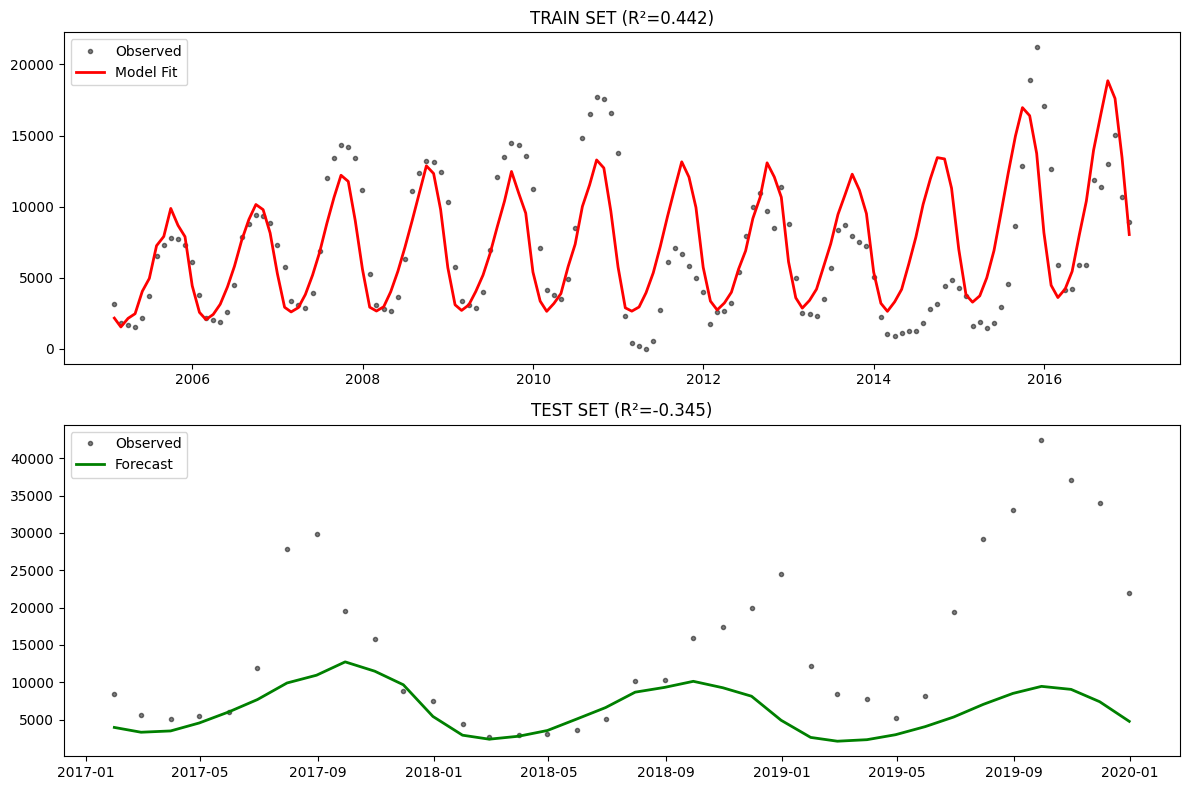

In [12]:
# --- Forecast & Evaluation (Improved Stability Version) ---

# 1. Split Data
split_idx = int(len(df) * 0.8)
df_train = df.iloc[:split_idx].copy()
df_test = df.iloc[split_idx:].copy()

print(f"Training set: {len(df_train)} months ({df_train.index[0].date()} → {df_train.index[-1].date()})")
print(f"Test set: {len(df_test)} months ({df_test.index[0].date()} → {df_test.index[-1].date()})")

# 2. Fit Scalers (FIX DATA LEAKAGE)
# Chỉ fit scaler trên tập train
climate_scaler_rain_train = StandardScaler()
climate_scaler_temp_train = StandardScaler()
rain_train_scaled = climate_scaler_rain_train.fit_transform(df_train[['rain_lag_raw']]).ravel()
temp_train_scaled = climate_scaler_temp_train.fit_transform(df_train[['temp_lag_raw']]).ravel()
# Transform tập test bằng scaler của train
rain_test_scaled = climate_scaler_rain_train.transform(df_test[['rain_lag_raw']]).ravel()
temp_test_scaled = climate_scaler_temp_train.transform(df_test[['temp_lag_raw']]).ravel()

# 3. Prepare Optimization Arrays
rain_train = rain_train_scaled.astype(float)
temp_train = temp_train_scaled.astype(float)
t_months_train = df_train['t_months'].values.astype(float)

rain_test = rain_test_scaled.astype(float)
temp_test = temp_test_scaled.astype(float)
t_months_test = df_test['t_months'].values.astype(float)

pop_train = df_train['N'].values.astype(float)
pop_test = df_test['N'].values.astype(float)
obs_train_counts = df_train['incidence'].values.astype(float)
obs_test_counts = df_test['incidence'].values.astype(float)

# Transform targets
obs_train_target, target_meta_split = fit_target_transform(obs_train_counts, pop_train)
obs_test_target = apply_target_transform(obs_test_counts, pop_test, target_meta_split)

# 4. Estimate Initial State & Debug Print
init_state_train = estimate_initial_state_improved(
    df_train['incidence'], 
    df_train['N'], 
    n_months=config.get('initial_state_n_months', 6) # Lấy trung bình nhiều tháng hơn để ổn định
)

print("\n" + "-"*40)
print("DEBUG: INITIAL STATE CHECK (TRAIN SET)")
print("-"*40)
print(f"Population (N0): {pop_train[0]:,.0f}")
print(f"S0 (Susceptible): {init_state_train[0]:,.0f} ({init_state_train[0]/pop_train[0]:.1%} of pop)")
print(f"E0 (Exposed):     {init_state_train[1]:,.0f}")
print(f"I0 (Infectious):  {init_state_train[2]:,.0f}")
print(f"R0 (Recovered):   {init_state_train[3]:,.0f}")
print("-"*40)

# 5. Run Calibration
print(f"\nOptimizing on training data (Restarts={config['random_restarts']})...")
train_bounds = build_bounds()

train_fit, train_runs = run_calibration(
    initial_state=init_state_train,
    populations=pop_train,
    rain_data=rain_train,
    temp_data=temp_train,
    t_months=t_months_train,
    observed_target=obs_train_target,
    bounds=train_bounds
)

if train_fit is None or not np.isfinite(train_fit.fun):
    print("WARNING: Optimization failed or returned infinite loss.")
else:
    params_train = train_fit.x
    print(f"Training optimisation loss: {train_fit.fun:.4f}")

    # 6. Simulate & Evaluate (Train)
    train_pred_counts, train_states = simulate_seir(params_train, init_state_train, pop_train, rain_train, temp_train, t_months_train)
    
    rmse_train = np.sqrt(mean_squared_error(obs_train_counts, train_pred_counts))
    mae_train = mean_absolute_error(obs_train_counts, train_pred_counts)
    r2_train = r2_score(obs_train_counts, train_pred_counts)
    cor_train = np.corrcoef(obs_train_counts, train_pred_counts)[0, 1]
    
    # 7. Simulate & Evaluate (Test)
    # Lấy trạng thái cuối cùng của tập Train làm trạng thái đầu của tập Test
    final_train_state = train_states[-1]
    # Điều chỉnh tỉ lệ dân số (nếu dân số thay đổi giữa tháng cuối train và đầu test)
    scale_factor = pop_test[0] / final_train_state.sum()
    init_state_test = np.clip(final_train_state * scale_factor, 0, None)

    test_pred_counts, _ = simulate_seir(params_train, init_state_test, pop_test, rain_test, temp_test, t_months_test)
    
    rmse_test = np.sqrt(mean_squared_error(obs_test_counts, test_pred_counts))
    mae_test = mean_absolute_error(obs_test_counts, test_pred_counts)
    r2_test = r2_score(obs_test_counts, test_pred_counts)
    cor_test = np.corrcoef(obs_test_counts, test_pred_counts)[0, 1]

    print("\n" + "="*40)
    print("IMPROVED RESULTS SUMMARY")
    print("="*40)
    print(f"Train RMSE: {rmse_train:,.2f} | MAE: {mae_train:,.2f} | R²: {r2_train:.4f} | Corr: {cor_train:.4f}")
    print(f"Test  RMSE: {rmse_test:,.2f}  | MAE: {mae_test:,.2f}  | R²: {r2_test:.4f} | Corr: {cor_test:.4f}")
    
    # Vẽ biểu đồ nhanh để kiểm tra
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    axes[0].plot(df_train.index, obs_train_counts, 'k.', alpha=0.5, label='Observed')
    axes[0].plot(df_train.index, train_pred_counts, 'r-', linewidth=2, label='Model Fit')
    axes[0].set_title(f'TRAIN SET (R²={r2_train:.3f})')
    axes[0].legend()
    
    axes[1].plot(df_test.index, obs_test_counts, 'k.', alpha=0.5, label='Observed')
    axes[1].plot(df_test.index, test_pred_counts, 'g-', linewidth=2, label='Forecast')
    axes[1].set_title(f'TEST SET (R²={r2_test:.3f})')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()


Training set: 144 months (2005-01-31 → 2016-12-31)
Test set: 36 months (2017-01-31 → 2019-12-31)

----------------------------------------
DEBUG: INITIAL STATE CHECK (TRAIN SET)
----------------------------------------
Population (N0): 81,088,313
S0 (Susceptible): 44,593,198 (55.0% of pop)
E0 (Exposed):     2,239
I0 (Infectious):  3,135
R0 (Recovered):   36,489,741
----------------------------------------

Optimizing on training data (Restarts=20)...
Training optimisation loss: 18.4823

IMPROVED RESULTS SUMMARY
Train RMSE: 3,494.49 | MAE: 2,618.34 | R²: 0.4514 | Corr: 0.6830
Test  RMSE: 12,334.25  | MAE: 8,331.74  | R²: -0.2725 | Corr: 0.6290


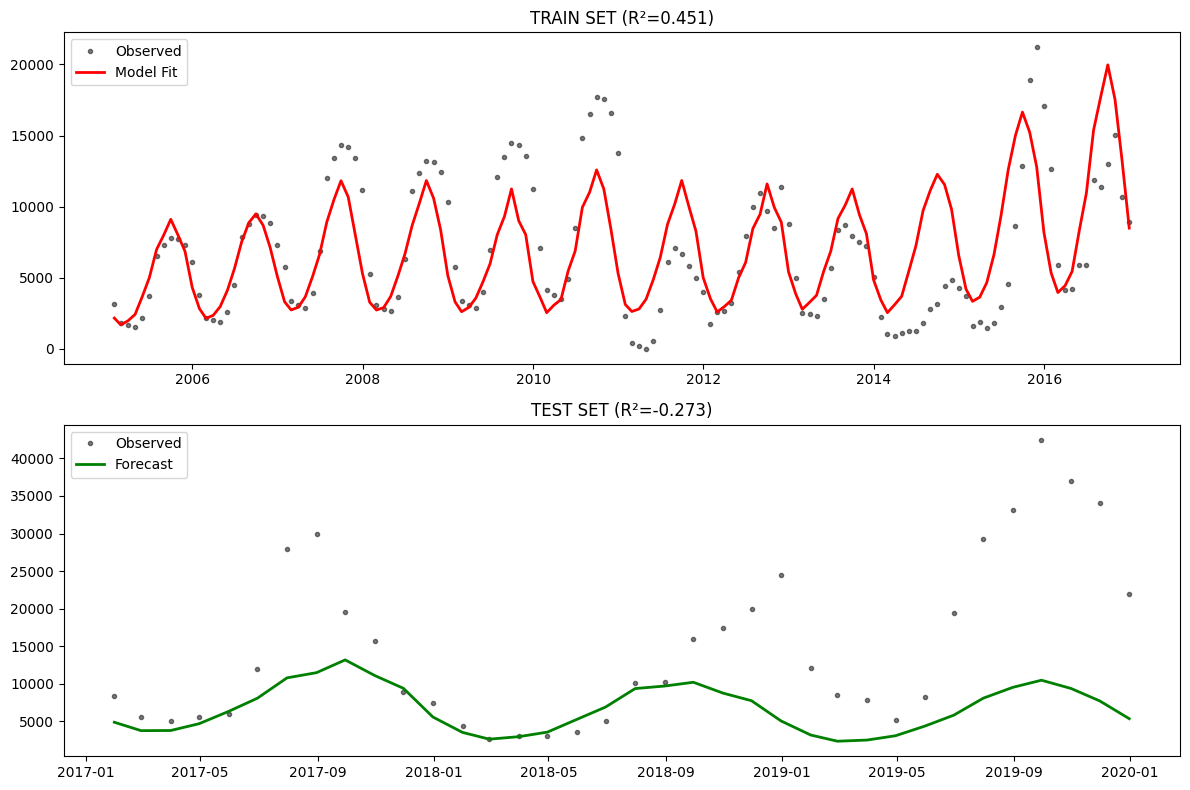

In [13]:
# --- Forecast & Evaluation (Improved Stability Version) ---

# 1. Split Data
split_idx = int(len(df) * 0.8)
df_train = df.iloc[:split_idx].copy()
df_test = df.iloc[split_idx:].copy()

print(f"Training set: {len(df_train)} months ({df_train.index[0].date()} → {df_train.index[-1].date()})")
print(f"Test set: {len(df_test)} months ({df_test.index[0].date()} → {df_test.index[-1].date()})")

# 2. Fit Scalers (FIX DATA LEAKAGE)
# Chỉ fit scaler trên tập train
climate_scaler_rain_train = StandardScaler()
climate_scaler_temp_train = StandardScaler()
rain_train_scaled = climate_scaler_rain_train.fit_transform(df_train[['rain_lag_raw']]).ravel()
temp_train_scaled = climate_scaler_temp_train.fit_transform(df_train[['temp_lag_raw']]).ravel()
# Transform tập test bằng scaler của train
rain_test_scaled = climate_scaler_rain_train.transform(df_test[['rain_lag_raw']]).ravel()
temp_test_scaled = climate_scaler_temp_train.transform(df_test[['temp_lag_raw']]).ravel()

# 3. Prepare Optimization Arrays
rain_train = rain_train_scaled.astype(float)
temp_train = temp_train_scaled.astype(float)
t_months_train = df_train['t_months'].values.astype(float)

rain_test = rain_test_scaled.astype(float)
temp_test = temp_test_scaled.astype(float)
t_months_test = df_test['t_months'].values.astype(float)

pop_train = df_train['N'].values.astype(float)
pop_test = df_test['N'].values.astype(float)
obs_train_counts = df_train['incidence'].values.astype(float)
obs_test_counts = df_test['incidence'].values.astype(float)

# Transform targets
obs_train_target, target_meta_split = fit_target_transform(obs_train_counts, pop_train)
obs_test_target = apply_target_transform(obs_test_counts, pop_test, target_meta_split)

# 4. Estimate Initial State & Debug Print
init_state_train = estimate_initial_state_improved(
    df_train['incidence'], 
    df_train['N'], 
    n_months=config.get('initial_state_n_months', 6) # Lấy trung bình nhiều tháng hơn để ổn định
)

print("\n" + "-"*40)
print("DEBUG: INITIAL STATE CHECK (TRAIN SET)")
print("-"*40)
print(f"Population (N0): {pop_train[0]:,.0f}")
print(f"S0 (Susceptible): {init_state_train[0]:,.0f} ({init_state_train[0]/pop_train[0]:.1%} of pop)")
print(f"E0 (Exposed):     {init_state_train[1]:,.0f}")
print(f"I0 (Infectious):  {init_state_train[2]:,.0f}")
print(f"R0 (Recovered):   {init_state_train[3]:,.0f}")
print("-"*40)

# 5. Run Calibration
print(f"\nOptimizing on training data (Restarts={config['random_restarts']})...")
train_bounds = build_bounds()

train_fit, train_runs = run_calibration(
    initial_state=init_state_train,
    populations=pop_train,
    rain_data=rain_train,
    temp_data=temp_train,
    t_months=t_months_train,
    observed_target=obs_train_target,
    bounds=train_bounds
)

if train_fit is None or not np.isfinite(train_fit.fun):
    print("WARNING: Optimization failed or returned infinite loss.")
else:
    params_train = train_fit.x
    print(f"Training optimisation loss: {train_fit.fun:.4f}")

    # 6. Simulate & Evaluate (Train)
    train_pred_counts, train_states = simulate_seir(params_train, init_state_train, pop_train, rain_train, temp_train, t_months_train)
    
    rmse_train = np.sqrt(mean_squared_error(obs_train_counts, train_pred_counts))
    mae_train = mean_absolute_error(obs_train_counts, train_pred_counts)
    r2_train = r2_score(obs_train_counts, train_pred_counts)
    cor_train = np.corrcoef(obs_train_counts, train_pred_counts)[0, 1]
    
    # 7. Simulate & Evaluate (Test)
    # Lấy trạng thái cuối cùng của tập Train làm trạng thái đầu của tập Test
    final_train_state = train_states[-1]
    # Điều chỉnh tỉ lệ dân số (nếu dân số thay đổi giữa tháng cuối train và đầu test)
    scale_factor = pop_test[0] / final_train_state.sum()
    init_state_test = np.clip(final_train_state * scale_factor, 0, None)

    test_pred_counts, _ = simulate_seir(params_train, init_state_test, pop_test, rain_test, temp_test, t_months_test)
    
    rmse_test = np.sqrt(mean_squared_error(obs_test_counts, test_pred_counts))
    mae_test = mean_absolute_error(obs_test_counts, test_pred_counts)
    r2_test = r2_score(obs_test_counts, test_pred_counts)
    cor_test = np.corrcoef(obs_test_counts, test_pred_counts)[0, 1]

    print("\n" + "="*40)
    print("IMPROVED RESULTS SUMMARY")
    print("="*40)
    print(f"Train RMSE: {rmse_train:,.2f} | MAE: {mae_train:,.2f} | R²: {r2_train:.4f} | Corr: {cor_train:.4f}")
    print(f"Test  RMSE: {rmse_test:,.2f}  | MAE: {mae_test:,.2f}  | R²: {r2_test:.4f} | Corr: {cor_test:.4f}")
    
    # Vẽ biểu đồ nhanh để kiểm tra
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    axes[0].plot(df_train.index, obs_train_counts, 'k.', alpha=0.5, label='Observed')
    axes[0].plot(df_train.index, train_pred_counts, 'r-', linewidth=2, label='Model Fit')
    axes[0].set_title(f'TRAIN SET (R²={r2_train:.3f})')
    axes[0].legend()
    
    axes[1].plot(df_test.index, obs_test_counts, 'k.', alpha=0.5, label='Observed')
    axes[1].plot(df_test.index, test_pred_counts, 'g-', linewidth=2, label='Forecast')
    axes[1].set_title(f'TEST SET (R²={r2_test:.3f})')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()


✓ Created sim_states_full from params_opt for compartments plot


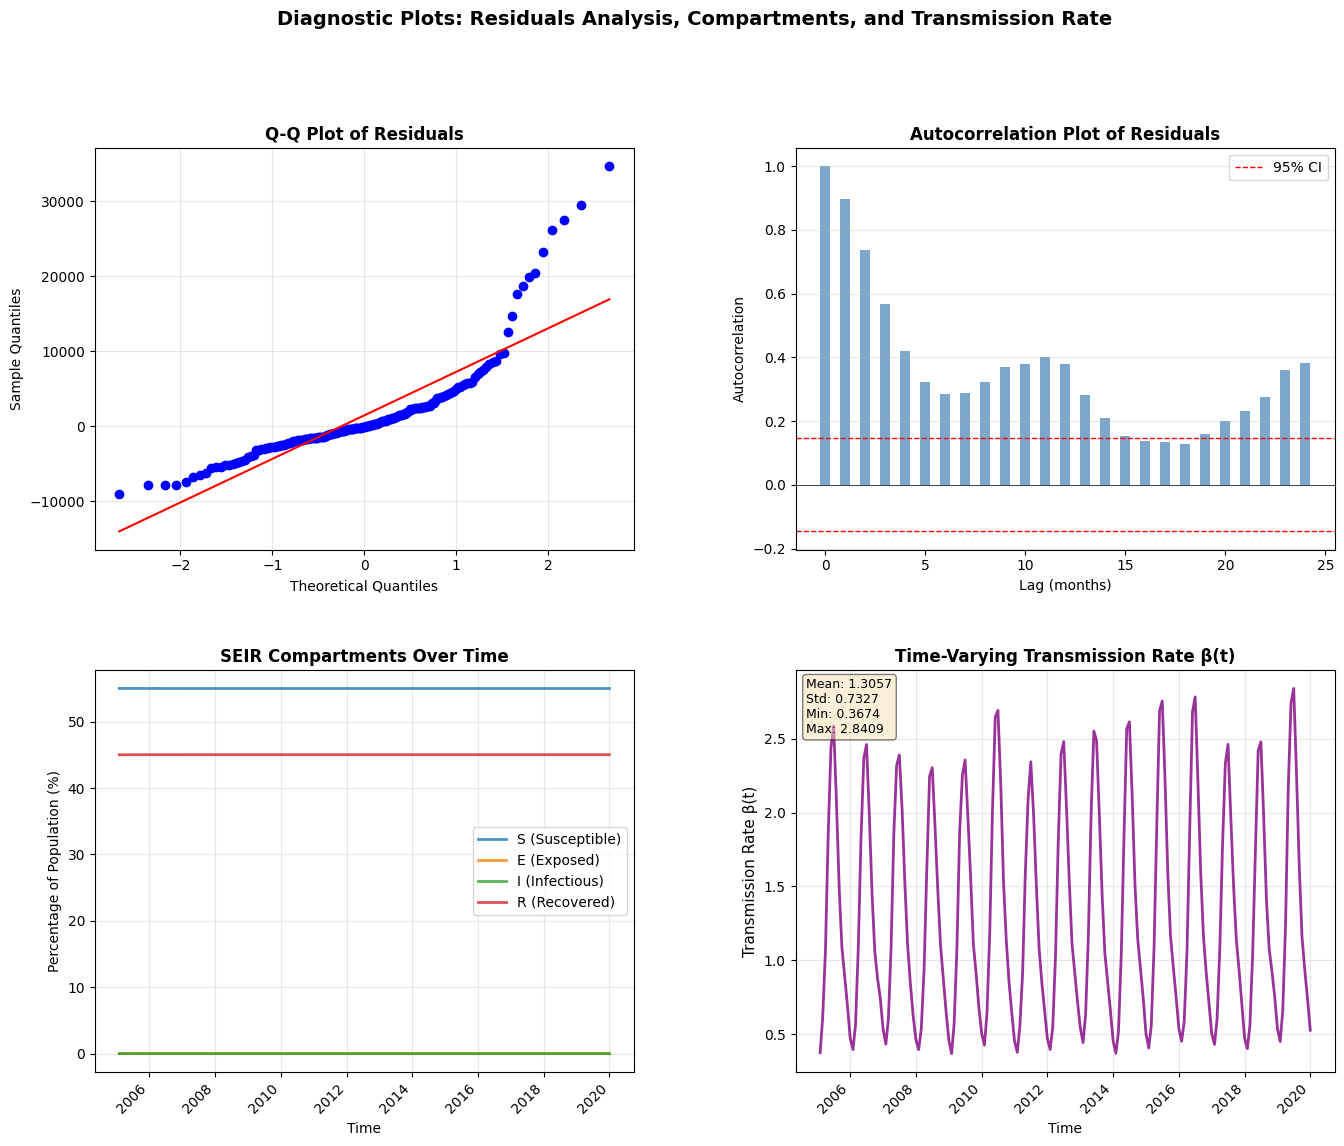


DIAGNOSTIC PLOTS SUMMARY

Residuals Statistics:
  Mean: 1454.26
  Std: 6548.11
  Min: -8987.63
  Max: 34695.08

Shapiro-Wilk Normality Test:
  Statistic: 0.7726
  p-value: 1.9852e-15
  → Residuals may not be normally distributed (p ≤ 0.05)

Significant Autocorrelations (|r| > 0.146):
  Lag 1: 0.897
  Lag 2: 0.738
  Lag 3: 0.569
  Lag 4: 0.419
  Lag 5: 0.322
  Lag 6: 0.284
  Lag 7: 0.288
  Lag 8: 0.322
  Lag 9: 0.371
  Lag 10: 0.380
  ... and 11 more


In [14]:
# --- Diagnostic Plots: Q-Q Plot, Autocorrelation, Compartments, and Beta(t) ---

from scipy import stats
try:
    from statsmodels.tsa.stattools import acf
    STATSMODELS_AVAILABLE = True
except ImportError:
    STATSMODELS_AVAILABLE = False
    print("Warning: statsmodels not available. Using numpy for autocorrelation calculation.")

# Check if we have the necessary variables from train/test split (Cell 9)
# Use sim_train_ma and sim_test_ma from 3-month moving average method
if 'sim_train_ma' in locals() and 'sim_test_ma' in locals() and 'obs_train_ma' in locals() and 'obs_test_ma' in locals() and 'df_train_ma' in locals() and 'df_test_ma' in locals():
    
    # Combine train and test data for diagnostics
    sim_incidence_combined = np.concatenate([sim_train_ma, sim_test_ma])
    obs_incidence_combined = np.concatenate([obs_train_ma, obs_test_ma])
    
    # Calculate residuals
    residuals = obs_incidence_combined - sim_incidence_combined
    
    # Create figure with 4 subplots
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)
    
    # Plot 1: Q-Q Plot of Residuals
    ax1 = fig.add_subplot(gs[0, 0])
    stats.probplot(residuals, dist="norm", plot=ax1)
    ax1.set_title('Q-Q Plot of Residuals', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Theoretical Quantiles')
    ax1.set_ylabel('Sample Quantiles')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Autocorrelation Plot of Residuals
    ax2 = fig.add_subplot(gs[0, 1])
    # Calculate autocorrelation with lags up to 24 months (2 years)
    max_lag = min(24, len(residuals) // 4)
    if STATSMODELS_AVAILABLE:
        autocorr = acf(residuals, nlags=max_lag, fft=False)
    else:
        # Fallback: manual autocorrelation calculation using numpy
        autocorr = np.array([np.corrcoef(residuals[:-i] if i > 0 else residuals, 
                                         residuals[i:])[0, 1] 
                            for i in range(max_lag + 1)])
    lags = np.arange(len(autocorr))
    
    ax2.bar(lags, autocorr, width=0.5, alpha=0.7, color='steelblue')
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    # Add 95% confidence intervals (approximate: ±1.96/sqrt(n))
    conf_interval = 1.96 / np.sqrt(len(residuals))
    ax2.axhline(y=conf_interval, color='red', linestyle='--', linewidth=1, label='95% CI')
    ax2.axhline(y=-conf_interval, color='red', linestyle='--', linewidth=1)
    ax2.set_title('Autocorrelation Plot of Residuals', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Lag (months)')
    ax2.set_ylabel('Autocorrelation')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Plot 3: SEIR Compartments Over Time
    ax3 = fig.add_subplot(gs[1, 0])
    
    # Create sim_states_full if it doesn't exist (for compartments plot)
    if ('sim_states_full' not in globals() or not isinstance(sim_states_full, np.ndarray) or 
        sim_states_full.ndim != 2 or sim_states_full.shape[1] != 4):
        # Try to create sim_states_full from params_opt and full dataset
        if 'params_opt' in globals() and 'df' in globals():
            try:
                # Check if we have the necessary functions and data
                if 'simulate_seir' in globals() and 'estimate_initial_state_improved' in globals():
                    # Get climate data columns
                    if 'rain_lag_scaled' in df.columns and 'temp_lag_scaled' in df.columns and 't_months' in df.columns and 'N' in df.columns:
                        # Estimate initial state
                        initial_state_full = estimate_initial_state_improved(df['incidence'], df['N'])
                        
                        # Prepare data for simulation
                        N_array = df['N'].values
                        rain_data = df['rain_lag_scaled'].values
                        temp_data = df['temp_lag_scaled'].values
                        t_months = df['t_months'].values
                        
                        # Run simulation
                        sim_incidence_full, sim_states_full = simulate_seir(
                            params_opt, initial_state_full, N_array, rain_data, temp_data, t_months
                        )
                        print("✓ Created sim_states_full from params_opt for compartments plot")
            except Exception as e:
                print(f"⚠ Warning: Could not create sim_states_full: {e}")
    
    if 'sim_states_full' in globals() and isinstance(sim_states_full, np.ndarray) and sim_states_full.ndim == 2 and sim_states_full.shape[1] == 4:
        S = sim_states_full[:, 0]
        E = sim_states_full[:, 1]
        I = sim_states_full[:, 2]
        R = sim_states_full[:, 3]

        if 'population_full' in globals() or 'N' in df.columns:
            if 'population_full' in globals():
                N_array = population_full if isinstance(population_full, np.ndarray) else population_full.values
            else:
                N_array = df['N'].values

            min_len = min(len(S), len(N_array))
            S_frac = S[:min_len] / N_array[:min_len] * 100
            E_frac = E[:min_len] / N_array[:min_len] * 100
            I_frac = I[:min_len] / N_array[:min_len] * 100
            R_frac = R[:min_len] / N_array[:min_len] * 100

            time_index = df.index[:min_len]

            ax3.plot(time_index, S_frac, label='S (Susceptible)', linewidth=2, alpha=0.8)
            ax3.plot(time_index, E_frac, label='E (Exposed)', linewidth=2, alpha=0.8)
            ax3.plot(time_index, I_frac, label='I (Infectious)', linewidth=2, alpha=0.8)
            ax3.plot(time_index, R_frac, label='R (Recovered)', linewidth=2, alpha=0.8)
            ax3.set_ylabel('Percentage of Population (%)')
        else:
            time_index = df.index[:len(S)]
            ax3.plot(time_index, S, label='S (Susceptible)', linewidth=2, alpha=0.8)
            ax3.plot(time_index, E, label='E (Exposed)', linewidth=2, alpha=0.8)
            ax3.plot(time_index, I, label='I (Infectious)', linewidth=2, alpha=0.8)
            ax3.plot(time_index, R, label='R (Recovered)', linewidth=2, alpha=0.8)
            ax3.set_ylabel('Number of Individuals')

        ax3.set_title('SEIR Compartments Over Time', fontsize=12, fontweight='bold')
        ax3.set_xlabel('Time')
        ax3.legend(loc='best')
        ax3.grid(True, alpha=0.3)
        plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')
    else:
        ax3.text(0.5, 0.5, 'Compartment data\nnot available\n(run in-sample evaluation first)',
                ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('SEIR Compartments', fontsize=12, fontweight='bold')

    # Plot 4: Beta(t) Over Time
    ax4 = fig.add_subplot(gs[1, 1])
    if 'params_opt' in globals():
        param_array = np.asarray(params_opt).ravel()
        if param_array.size >= 7:
            beta0, b_rain, b_temp, alpha1, phi1, alpha2, phi2 = param_array[:7]

            if 'rain_lag_scaled' in df.columns and 'temp_lag_scaled' in df.columns and 't_months' in df.columns:
                rain_data = df['rain_lag_scaled'].values
                temp_data = df['temp_lag_scaled'].values
                t_months = df['t_months'].values

                beta_t = []
                for idx_beta in range(len(df)):
                    climate_part = np.exp(b_rain * rain_data[idx_beta] + b_temp * temp_data[idx_beta])
                    t_val = t_months[idx_beta]
                    fourier_part = 1.0 + alpha1 * np.sin(2 * np.pi * t_val / 12.0 + phi1) + alpha2 * np.sin(2 * np.pi * t_val / 6.0 + phi2)
                    fourier_part = max(1e-6, fourier_part)
                    beta_val = np.exp(beta0) * climate_part * fourier_part
                    beta_t.append(beta_val)

                beta_t = np.array(beta_t)

                ax4.plot(df.index, beta_t, '-', linewidth=2, color='purple', alpha=0.8)
                ax4.set_ylabel('Transmission Rate β(t)', fontsize=11)
                ax4.set_title('Time-Varying Transmission Rate β(t)', fontsize=12, fontweight='bold')
                ax4.set_xlabel('Time')
                ax4.grid(True, alpha=0.3)
                plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')

                mean_beta = np.mean(beta_t)
                std_beta = np.std(beta_t)
                min_beta = np.min(beta_t)
                max_beta = np.max(beta_t)
                stats_text = f'Mean: {mean_beta:.4f}\nStd: {std_beta:.4f}\nMin: {min_beta:.4f}\nMax: {max_beta:.4f}'
                ax4.text(0.02, 0.98, stats_text, transform=ax4.transAxes,
                        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                        fontsize=9)
            else:
                ax4.text(0.5, 0.5, 'Climate data\nnot available',
                        ha='center', va='center', transform=ax4.transAxes)
                ax4.set_title('Time-Varying Transmission Rate', fontsize=12, fontweight='bold')
        else:
            ax4.text(0.5, 0.5, 'Parameters not available\n(run calibration cell)',
                    ha='center', va='center', transform=ax4.transAxes)
            ax4.set_title('Time-Varying Transmission Rate', fontsize=12, fontweight='bold')
    else:
        ax4.text(0.5, 0.5, 'Parameters not available\n(run calibration cell)',
                ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Time-Varying Transmission Rate', fontsize=12, fontweight='bold')
    plt.suptitle('Diagnostic Plots: Residuals Analysis, Compartments, and Transmission Rate', 
                 fontsize=14, fontweight='bold', y=0.995)
    plt.show()
    
    # Print summary statistics
    print("\n" + "=" * 80)
    print("DIAGNOSTIC PLOTS SUMMARY")
    print("=" * 80)
    print(f"\nResiduals Statistics:")
    print(f"  Mean: {np.mean(residuals):.2f}")
    print(f"  Std: {np.std(residuals):.2f}")
    print(f"  Min: {np.min(residuals):.2f}")
    print(f"  Max: {np.max(residuals):.2f}")
    
    # Normality test
    from scipy.stats import shapiro
    if len(residuals) <= 5000:  # Shapiro-Wilk test works for n <= 5000
        stat, p_value = shapiro(residuals)
        print(f"\nShapiro-Wilk Normality Test:")
        print(f"  Statistic: {stat:.4f}")
        print(f"  p-value: {p_value:.4e}")
        if p_value > 0.05:
            print(f"  → Residuals appear to be normally distributed (p > 0.05)")
        else:
            print(f"  → Residuals may not be normally distributed (p ≤ 0.05)")
    
    # Autocorrelation summary
    significant_lags = np.where(np.abs(autocorr[1:]) > conf_interval)[0] + 1
    if len(significant_lags) > 0:
        print(f"\nSignificant Autocorrelations (|r| > {conf_interval:.3f}):")
        for lag in significant_lags[:10]:  # Show first 10
            print(f"  Lag {lag}: {autocorr[lag]:.3f}")
        if len(significant_lags) > 10:
            print(f"  ... and {len(significant_lags) - 10} more")
    else:
        print(f"\nNo significant autocorrelations found (all |r| ≤ {conf_interval:.3f})")
    
    print("=" * 80)
    
else:
    print("ERROR: Required variables not found. Please run Cell 9 (3-Month Moving Average calibration) first.")
    print("Required variables: sim_train_ma, sim_test_ma, obs_train_ma, obs_test_ma, df_train_ma, df_test_ma")


RMSE (counts):      3,712.11
MAE (counts):       2,805.35
R² (counts):         0.7336
Corr (counts):       0.8621
RMSE (target):       4.0124
MAE (target):        3.0729
R² (target):         0.7167
Corr (target):       0.8517
Log-RMSE (target):   0.6444


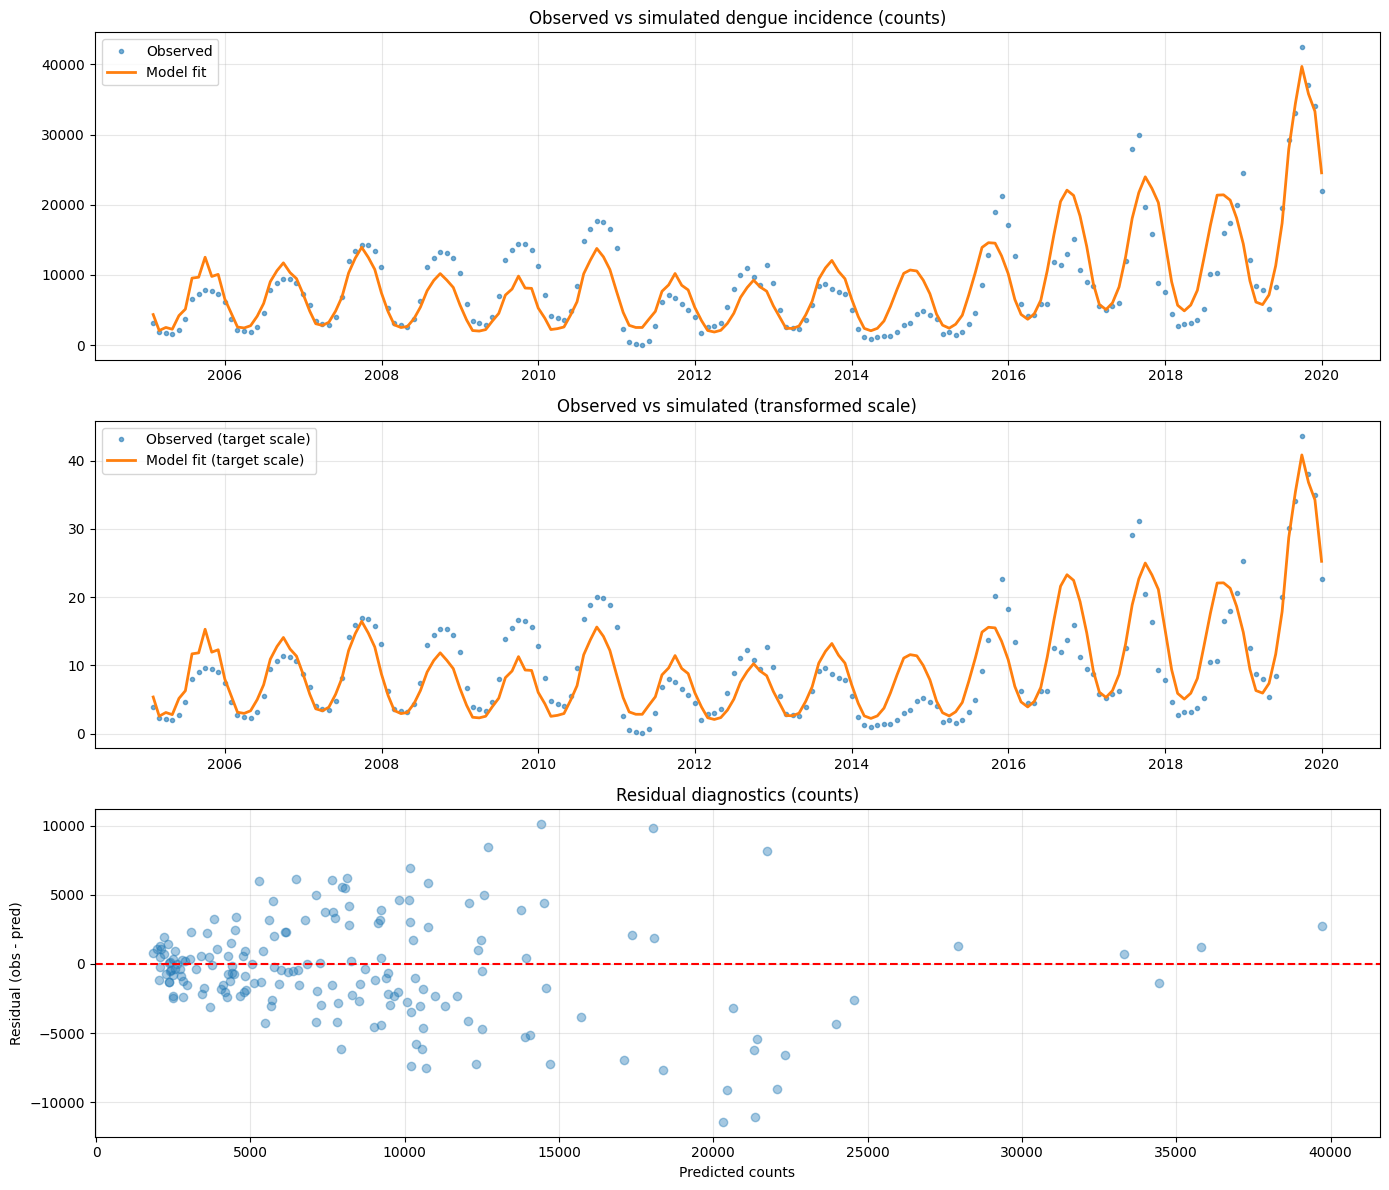

In [15]:
# --- In-sample evaluation (counts + transformed scale) ---
sim_incidence_full, sim_states_full = simulate_seir(
    params_opt,
    init_state,
    population_full,
    rain_data_full,
    temp_data_full,
    t_months_full
)

pred_counts = sim_incidence_full
obs_counts = observed_cases_full
pred_target = transform_cases_to_target(pred_counts, population_full)
obs_target = observed_target_full

rmse_counts = np.sqrt(mean_squared_error(obs_counts, pred_counts))
mae_counts = mean_absolute_error(obs_counts, pred_counts)
r2_counts = r2_score(obs_counts, pred_counts)
cor_counts = np.corrcoef(obs_counts, pred_counts)[0, 1]

rmse_target = np.sqrt(mean_squared_error(obs_target, pred_target))
mae_target = mean_absolute_error(obs_target, pred_target)
r2_target = r2_score(obs_target, pred_target)
cor_target = np.corrcoef(obs_target, pred_target)[0, 1]

log_obs = np.log(obs_target + config['loss_epsilon'])
log_pred = np.log(pred_target + config['loss_epsilon'])
log_rmse = np.sqrt(np.mean((log_obs - log_pred) ** 2))

print(f"RMSE (counts):      {rmse_counts:,.2f}")
print(f"MAE (counts):       {mae_counts:,.2f}")
print(f"R² (counts):        {r2_counts: .4f}")
print(f"Corr (counts):      {cor_counts: .4f}")
print(f"RMSE (target):      {rmse_target: .4f}")
print(f"MAE (target):       {mae_target: .4f}")
print(f"R² (target):        {r2_target: .4f}")
print(f"Corr (target):      {cor_target: .4f}")
print(f"Log-RMSE (target):  {log_rmse: .4f}")

fig, axes = plt.subplots(3, 1, figsize=(14, 12))
axes[0].plot(df.index, obs_counts, 'o', label='Observed', markersize=3, alpha=0.6)
axes[0].plot(df.index, pred_counts, '-', label='Model fit', linewidth=2)
axes[0].set_title('Observed vs simulated dengue incidence (counts)')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(df.index, obs_target, 'o', label='Observed (target scale)', markersize=3, alpha=0.6)
axes[1].plot(df.index, pred_target, '-', label='Model fit (target scale)', linewidth=2)
axes[1].set_title('Observed vs simulated (transformed scale)')
axes[1].legend()
axes[1].grid(alpha=0.3)

residuals = obs_counts - pred_counts
axes[2].scatter(pred_counts, residuals, alpha=0.4)
axes[2].axhline(0, color='red', linestyle='--')
axes[2].set_xlabel('Predicted counts')
axes[2].set_ylabel('Residual (obs - pred)')
axes[2].set_title('Residual diagnostics (counts)')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()



               ══════════════════════════════════════════════════
               TỔNG HỢP KẾT QUẢ PROJECT - FREQUENTIST APPROACH
               ══════════════════════════════════════════════════

1. THÔNG TIN MÔ HÌNH

📊 Mô hình: Discrete-Time SEIR với Climate Covariates
   • Time step: 1 tháng
   • Compartments: S (Susceptible), E (Exposed), I (Infectious), R (Recovered)
   • Climate covariates: Rainfall & Temperature (3-month moving average)
   • Transmission rate: β(t) = β₀·exp(b_rain·rain + b_temp·temp)·[1 + Fourier]
   • Loss function: Absolute Loss
   • Regularization: ✓ Có (L2=0.1)
   • Weighted loss: ✓ Có
   • Approach: ✓ FREQUENTIST (Maximum Likelihood Estimation)

📈 Dữ liệu:
   • Thời gian: 2005-01-31 → 2019-12-31
   • Số tháng: 180 months
   • Tổng số ca: 1,517,514 cases
   • Trung bình/tháng: 8,431 cases
   • Max/tháng: 42,451 cases
   • Min/tháng: 19 cases

2. CALIBRATED PARAMETERS (FREQUENTIST MLE)

Parameter  MLE Value       Description                             
------

C:\Users\Pht Technology\AppData\Local\Temp\ipykernel_19232\2383017214.py:292: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


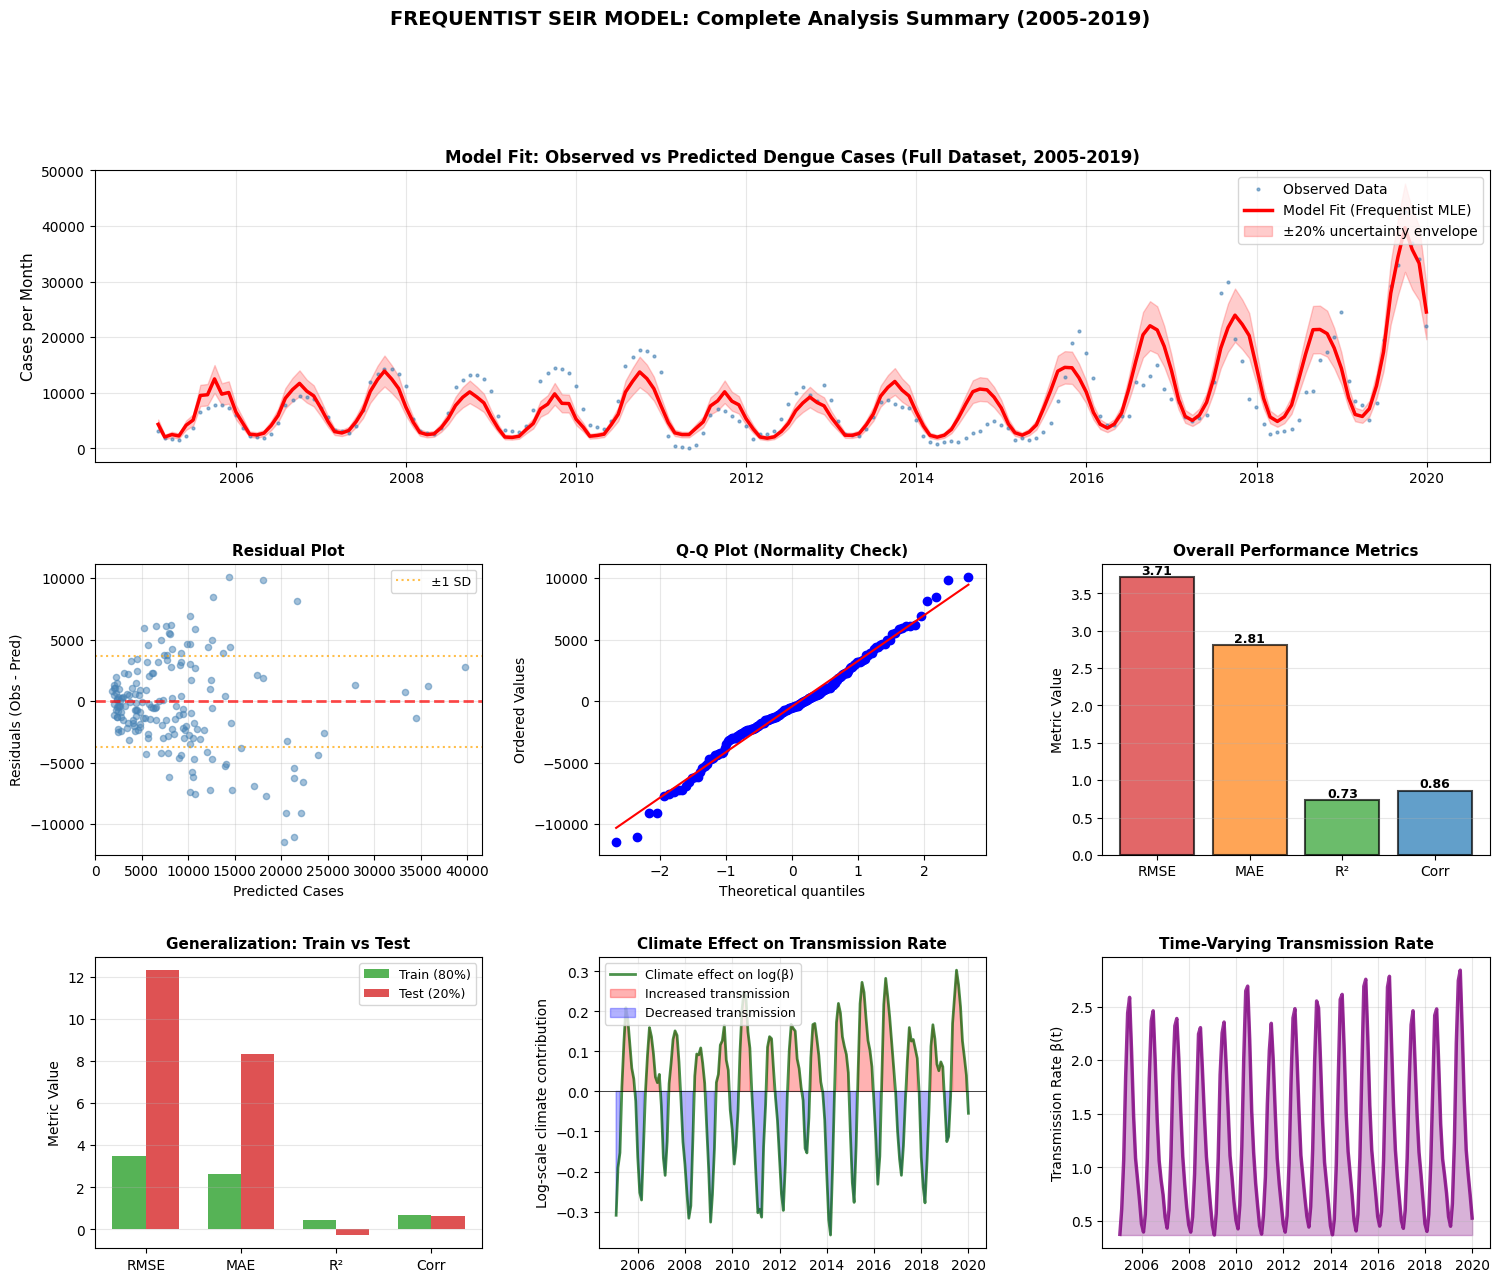

In [16]:
# --- TỔNG HỢP KẾT QUẢ PROJECT (FREQUENTIST ONLY) ---

print(" " * 15 + "═" * 50)
print(" " * 15 + "TỔNG HỢP KẾT QUẢ PROJECT - FREQUENTIST APPROACH")
print(" " * 15 + "═" * 50)

print("\n" + "=" * 80)
print("1. THÔNG TIN MÔ HÌNH")
print("=" * 80)

print("\n📊 Mô hình: Discrete-Time SEIR với Climate Covariates")
print(f"   • Time step: 1 tháng")
print(f"   • Compartments: S (Susceptible), E (Exposed), I (Infectious), R (Recovered)")
print(f"   • Climate covariates: Rainfall & Temperature (3-month moving average)")
print(f"   • Transmission rate: β(t) = β₀·exp(b_rain·rain + b_temp·temp)·[1 + Fourier]")
print(f"   • Loss function: {'Absolute Loss' if not config.get('loss_on_log_scale', False) else 'Log-Scale Loss'}")
print(f"   • Regularization: {'✓ Có' if config.get('use_regularization', False) else '✗ Không'} (L2={config.get('l2_regularization', 0)})")
print(f"   • Weighted loss: {'✓ Có' if config.get('use_weighted_loss', False) else '✗ Không'}")
print(f"   • Approach: ✓ FREQUENTIST (Maximum Likelihood Estimation)")

# Thông tin dữ liệu
if 'df' in globals():
    print(f"\n📈 Dữ liệu:")
    print(f"   • Thời gian: {df.index[0].date()} → {df.index[-1].date()}")
    print(f"   • Số tháng: {len(df)} months")
    print(f"   • Tổng số ca: {df['incidence'].sum():,.0f} cases")
    print(f"   • Trung bình/tháng: {df['incidence'].mean():,.0f} cases")
    print(f"   • Max/tháng: {df['incidence'].max():,.0f} cases")
    print(f"   • Min/tháng: {df['incidence'].min():,.0f} cases")

print("\n" + "=" * 80)
print("2. CALIBRATED PARAMETERS (FREQUENTIST MLE)")
print("=" * 80)

if 'params_opt' in locals():
    param_names = ['β₀', 'b_rain', 'b_temp', 'α₁', 'φ₁', 'α₂', 'φ₂', 'σ', 'γ']
    param_descriptions = [
        'Base transmission rate (log-scale)',
        'Rainfall effect coefficient',
        'Temperature effect coefficient',
        'Fourier amplitude (12-month)',
        'Fourier phase (12-month)',
        'Fourier amplitude (6-month)',
        'Fourier phase (6-month)',
        'Incubation rate (per month)',
        'Recovery rate (per month)'
    ]
    
    print(f"\n{'Parameter':<10} {'MLE Value':<15} {'Description':<40}")
    print("-" * 80)
    for i, (name, val, desc) in enumerate(zip(param_names, params_opt, param_descriptions)):
        if name in ['φ₁', 'φ₂']:
            print(f"{name:<10} {val:>14.6f}  {desc:<40} ({val*180/np.pi:>6.1f}°)")
        else:
            print(f"{name:<10} {val:>14.6f}  {desc:<40}")
    
    # Kiểm tra constraints
    alpha1 = params_opt[3]
    alpha2 = params_opt[5]
    fourier_sum = alpha1 + alpha2
    fourier_max = config.get('fourier_sum_max', 0.8)
    
    print(f"\n✓ Fourier constraint: α₁ + α₂ = {fourier_sum:.4f} < {fourier_max}")
    if config.get('fixed_sigma') is not None:
        print(f"✓ Fixed σ = {config.get('fixed_sigma')} (incubation ≈ {1/config.get('fixed_sigma'):.2f} months ≈ {30/config.get('fixed_sigma'):.1f} days)")
    if config.get('fixed_gamma') is not None:
        print(f"✓ Fixed γ = {config.get('fixed_gamma')} (infectious ≈ {1/config.get('fixed_gamma'):.2f} months ≈ {30/config.get('fixed_gamma'):.1f} days)")

print("\n" + "=" * 80)
print("3. MODEL PERFORMANCE - IN-SAMPLE (FULL DATASET)")
print("=" * 80)

if 'params_opt' in locals() and 'sim_incidence_full' in locals():
    print(f"\n{'Metric':<25} {'Value':<15} {'Evaluation':<25}")
    print("-" * 80)
    
    metrics_counts = [
        ('RMSE (counts)', rmse_counts, f"{'✓ Excellent' if rmse_counts < 5000 else '✓ Good' if rmse_counts < 10000 else '⚠ Fair' if rmse_counts < 20000 else '✗ Poor'}"),
        ('MAE (counts)', mae_counts, ''),
        ('R² (counts)', r2_counts, f"{'✓ Excellent' if r2_counts > 0.8 else '✓ Good' if r2_counts > 0.6 else '⚠ Fair' if r2_counts > 0.4 else '✗ Poor'}"),
        ('Correlation', cor_counts, f"{'✓ Excellent' if cor_counts > 0.85 else '✓ Good' if cor_counts > 0.75 else '⚠ Fair' if cor_counts > 0.6 else '✗ Poor'}"),
    ]
    
    for name, val, eval_text in metrics_counts:
        if 'R²' in name or 'Correlation' in name:
            print(f"{name:<25} {val:>14.4f}  {eval_text:<25}")
        else:
            print(f"{name:<25} {val:>14,.2f}  {eval_text:<25}")
    
    print(f"\n{'Metric (transformed)':<25} {'Value':<15}")
    print("-" * 80)
    print(f"{'RMSE (target scale)':<25} {rmse_target:>14.4f}")
    print(f"{'MAE (target scale)':<25} {mae_target:>14.4f}")
    print(f"{'R² (target scale)':<25} {r2_target:>14.4f}")
    print(f"{'Log-RMSE':<25} {log_rmse:>14.4f}")

# Train/Test metrics
if 'rmse_train' in locals() and 'rmse_test' in locals():
    print("\n" + "=" * 80)
    print("4. MODEL PERFORMANCE - TRAIN/TEST SPLIT (80/20)")
    print("=" * 80)
    
    print(f"\n{'Metric':<25} {'Train':<15} {'Test':<15} {'Generalization':<15}")
    print("-" * 80)
    
    train_test_metrics = [
        ('RMSE (counts)', rmse_train, rmse_test),
        ('MAE (counts)', mae_train, mae_test),
        ('R² (counts)', r2_train, r2_test),
        ('Correlation', cor_train, cor_test),
    ]
    
    for name, train_val, test_val in train_test_metrics:
        if 'R²' in name or 'Correlation' in name:
            diff = abs(train_val - test_val)
            status = "✓ Good" if diff < 0.1 else "⚠ Acceptable" if diff < 0.2 else "✗ Poor"
        else:
            ratio = test_val / train_val if train_val > 0 else 1.0
            status = "✓ Good" if 0.8 <= ratio <= 1.3 else "⚠ Acceptable" if 0.6 <= ratio <= 1.5 else "✗ Poor"
        
        if 'R²' in name or 'Correlation' in name:
            print(f"{name:<25} {train_val:>14.4f}  {test_val:>14.4f}  {status:<15}")
        else:
            print(f"{name:<25} {train_val:>14,.2f}  {test_val:>14,.2f}  {status:<15}")

print("\n" + "=" * 80)
print("5. KEY INSIGHTS & INTERPRETATIONS")
print("=" * 80)

if 'params_opt' in locals():
    print(f"\n🔬 Parameter Interpretation:")
    
    # β₀ (baseline transmission)
    beta0_exp = np.exp(params_opt[0])
    print(f"   • Baseline transmission β₀ = {params_opt[0]:.4f}")
    print(f"     → exp(β₀) = {beta0_exp:.4f} (baseline cases per infectious individual)")
    
    # Climate effects
    b_rain = params_opt[1]
    b_temp = params_opt[2]
    print(f"\n   • Rainfall effect (b_rain) = {b_rain:+.4f}")
    if abs(b_rain) < 0.05:
        print(f"     → Weak/negligible effect on transmission")
    elif b_rain > 0:
        print(f"     → Higher rainfall → INCREASED transmission (positive feedback)")
    else:
        print(f"     → Higher rainfall → DECREASED transmission (negative feedback)")
    
    print(f"\n   • Temperature effect (b_temp) = {b_temp:+.4f}")
    if abs(b_temp) < 0.05:
        print(f"     → Weak/negligible effect on transmission")
    elif b_temp > 0:
        print(f"     → Higher temperature → INCREASED transmission (warmer → more dengue)")
    else:
        print(f"     → Higher temperature → DECREASED transmission (cooling effect)")
    
    # Seasonality
    print(f"\n   • Seasonality (Fourier components):")
    print(f"     - 12-month cycle: amplitude={params_opt[3]:.4f}, phase={params_opt[4]*180/np.pi:.1f}°")
    print(f"     - 6-month cycle:  amplitude={params_opt[5]:.4f}, phase={params_opt[6]*180/np.pi:.1f}°")
    
    # Biological parameters
    sigma = params_opt[7]
    gamma = params_opt[8]
    print(f"\n   • Biological parameters:")
    print(f"     - Incubation: σ = {sigma:.4f}/month ≈ {1/sigma:.2f} months ≈ {30/sigma:.1f} days")
    print(f"     - Recovery:  γ = {gamma:.4f}/month ≈ {1/gamma:.2f} months ≈ {30/gamma:.1f} days")

print("\n" + "=" * 80)
print("6. VISUALIZATION SUMMARY")
print("=" * 80)

# Tạo comprehensive visualization
fig = plt.figure(figsize=(18, 14))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# Plot 1: Time series fit (counts)
ax1 = fig.add_subplot(gs[0, :])
if 'params_opt' in locals() and 'sim_incidence_full' in locals() and 'df' in globals():
    ax1.plot(df.index, df['incidence'], 'o', label='Observed Data', markersize=2, alpha=0.6, color='steelblue')
    ax1.plot(df.index, sim_incidence_full, '-', label='Model Fit (Frequentist MLE)', linewidth=2.5, color='red')
    ax1.fill_between(df.index, sim_incidence_full * 0.8, sim_incidence_full * 1.2, 
                      alpha=0.2, color='red', label='±20% uncertainty envelope')
    ax1.set_title('Model Fit: Observed vs Predicted Dengue Cases (Full Dataset, 2005-2019)', 
                  fontsize=12, fontweight='bold')
    ax1.set_ylabel('Cases per Month', fontsize=11)
    ax1.legend(loc='upper right', fontsize=10)
    ax1.grid(alpha=0.3)

# Plot 2: Residuals scatter
ax2 = fig.add_subplot(gs[1, 0])
if 'params_opt' in locals() and 'sim_incidence_full' in locals() and 'df' in globals():
    residuals = df['incidence'].values - sim_incidence_full
    ax2.scatter(sim_incidence_full, residuals, alpha=0.5, s=20, color='steelblue')
    ax2.axhline(0, color='red', linestyle='--', linewidth=2, alpha=0.7)
    ax2.axhline(np.std(residuals), color='orange', linestyle=':', linewidth=1.5, alpha=0.7, label='±1 SD')
    ax2.axhline(-np.std(residuals), color='orange', linestyle=':', linewidth=1.5, alpha=0.7)
    ax2.set_xlabel('Predicted Cases', fontsize=10)
    ax2.set_ylabel('Residuals (Obs - Pred)', fontsize=10)
    ax2.set_title('Residual Plot', fontsize=11, fontweight='bold')
    ax2.legend(fontsize=9)
    ax2.grid(alpha=0.3)

# Plot 3: Q-Q plot
ax3 = fig.add_subplot(gs[1, 1])
if 'params_opt' in locals() and 'sim_incidence_full' in locals() and 'df' in globals():
    from scipy import stats
    residuals = df['incidence'].values - sim_incidence_full
    stats.probplot(residuals, dist="norm", plot=ax3)
    ax3.set_title('Q-Q Plot (Normality Check)', fontsize=11, fontweight='bold')
    ax3.grid(alpha=0.3)

# Plot 4: Performance metrics
ax4 = fig.add_subplot(gs[1, 2])
if 'params_opt' in locals() and 'sim_incidence_full' in locals():
    metrics_names = ['RMSE', 'MAE', 'R²', 'Corr']
    metrics_values = [rmse_counts/1000, mae_counts/1000, r2_counts, cor_counts]
    colors_list = ['#d62728', '#ff7f0e', '#2ca02c', '#1f77b4']
    bars = ax4.bar(metrics_names, metrics_values, color=colors_list, alpha=0.7, edgecolor='black', linewidth=1.5)
    ax4.set_ylabel('Metric Value', fontsize=10)
    ax4.set_title('Overall Performance Metrics', fontsize=11, fontweight='bold')
    ax4.grid(alpha=0.3, axis='y')
    # Add value labels
    for bar, val in zip(bars, metrics_values):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 5: Train vs Test
ax5 = fig.add_subplot(gs[2, 0])
if 'rmse_train' in locals() and 'rmse_test' in locals():
    train_metrics = [rmse_train/1000, mae_train/1000, r2_train, cor_train]
    test_metrics = [rmse_test/1000, mae_test/1000, r2_test, cor_test]
    x = np.arange(len(metrics_names))
    width = 0.35
    ax5.bar(x - width/2, train_metrics, width, label='Train (80%)', alpha=0.8, color='#2ca02c')
    ax5.bar(x + width/2, test_metrics, width, label='Test (20%)', alpha=0.8, color='#d62728')
    ax5.set_xticks(x)
    ax5.set_xticklabels(metrics_names)
    ax5.set_ylabel('Metric Value', fontsize=10)
    ax5.set_title('Generalization: Train vs Test', fontsize=11, fontweight='bold')
    ax5.legend(fontsize=9)
    ax5.grid(alpha=0.3, axis='y')

# Plot 6: Climate effects on transmission
ax6 = fig.add_subplot(gs[2, 1])
if 'params_opt' in locals() and 'df' in globals():
    beta0 = params_opt[0]
    b_rain = params_opt[1]
    b_temp = params_opt[2]
    
    if 'rain_lag_scaled' in df.columns and 'temp_lag_scaled' in df.columns:
        # Calculate climate-only contribution to log(beta)
        climate_logbeta = b_rain * df['rain_lag_scaled'].values + b_temp * df['temp_lag_scaled'].values
        
        ax6.plot(df.index, climate_logbeta, '-', linewidth=2, color='darkgreen', alpha=0.7, label='Climate effect on log(β)')
        ax6.axhline(0, color='black', linestyle='-', linewidth=0.5)
        ax6.fill_between(df.index, climate_logbeta, 0, where=(climate_logbeta >= 0), 
                         alpha=0.3, color='red', label='Increased transmission')
        ax6.fill_between(df.index, climate_logbeta, 0, where=(climate_logbeta < 0), 
                         alpha=0.3, color='blue', label='Decreased transmission')
        ax6.set_ylabel('Log-scale climate contribution', fontsize=10)
        ax6.set_title('Climate Effect on Transmission Rate', fontsize=11, fontweight='bold')
        ax6.legend(fontsize=9)
        ax6.grid(alpha=0.3)

# Plot 7: Time-varying transmission rate
ax7 = fig.add_subplot(gs[2, 2])
if 'params_opt' in locals() and 'df' in globals():
    beta0 = params_opt[0]
    b_rain = params_opt[1]
    b_temp = params_opt[2]
    alpha1 = params_opt[3]
    phi1 = params_opt[4]
    alpha2 = params_opt[5]
    phi2 = params_opt[6]
    
    if 'rain_lag_scaled' in df.columns and 'temp_lag_scaled' in df.columns:
        t_months = df['t_months'].values
        climate_part = np.exp(b_rain * df['rain_lag_scaled'].values + b_temp * df['temp_lag_scaled'].values)
        fourier_part = 1.0 + alpha1 * np.sin(2*np.pi*t_months/12 + phi1) + alpha2 * np.sin(2*np.pi*t_months/6 + phi2)
        beta_t = np.exp(beta0) * climate_part * fourier_part
        
        ax7.plot(df.index, beta_t, '-', linewidth=2.5, color='purple', alpha=0.8)
        ax7.fill_between(df.index, beta_t.min(), beta_t, alpha=0.3, color='purple')
        ax7.set_ylabel('Transmission Rate β(t)', fontsize=10)
        ax7.set_title('Time-Varying Transmission Rate', fontsize=11, fontweight='bold')
        ax7.grid(alpha=0.3)

plt.suptitle('FREQUENTIST SEIR MODEL: Complete Analysis Summary (2005-2019)', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()